<a href="https://colab.research.google.com/github/Jonkkeyler333/preciCol/blob/main/notebooks/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Analisis Exploratorio de Datos (EDA)**

## Librerías necesarias

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit ,to_timestamp, dayofmonth, month, year
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
##OJO ESTO SOLO ES PARA USAR DRIVE , SE DEBE QUITAR
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Preprocesamiento Inicial

In [51]:
def preprocesar_ciudad(city):
    try:
        path = f'./drive/MyDrive/data_project/enriched/{city}'
        df = spark.read.parquet(path)
        print(f'\n>>> Resumen del DataFrame original para {city}:\n')
        df.show(5)

        df = df.withColumn("dia", dayofmonth(col("time")))
        df = df.withColumn("mes", month(col("time")))
        df = df.withColumn("año", year(col("time")))
        df = df.dropna()

        print(f'\n>>> Esquema actualizado para {city} después del preprocesamiento:\n')
        df.printSchema()

        df = df.toPandas()
        df.set_index('time', inplace=True)
        df['coco'] = df['coco'].astype('int')
        return df
    except Exception as e:
        print(f"Error procesando la ciudad {city}: {e}")
        return None

In [22]:
#@title Inicializacion del Spark Context
plt.style.use('ggplot')
CITIES=['SOLEDAD','CARTAGENA DE INDIAS','VALLEDUPAR','BOGOTA D.C','NEIVA','RIOHACHA','PASTO','CÚCUTA','ARMENIA','SAN ANDRÉS']
spark = SparkSession.builder.appName('EDA').getOrCreate()

# Analisis Sogamoso (Opcional)




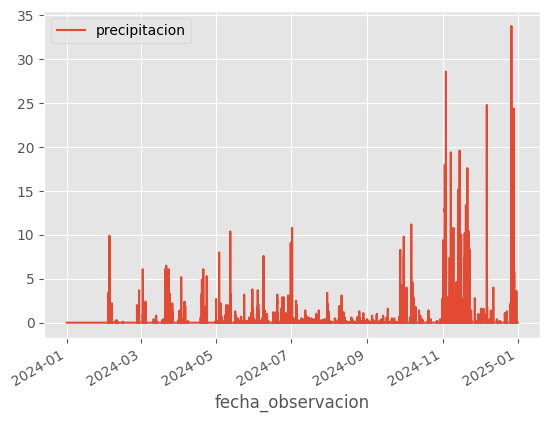

In [ ]:
## Tener cuidado con sogamoso
path_sogamoso=f'./drive/MyDrive/data_project/enriched/SOGAMOSO'
df_original=spark.read.parquet(path_sogamoso)
df_pd=df_original.toPandas()
df_pd.set_index('fecha_observacion',inplace=True)
df_pd.plot(y='precipitacion')
plt.show()
del df_pd
del df_original


# Definicion de Funciones

In [14]:
def analizar_ciudad(df_preprocesado, mostrar_head=True, graficar=True):
    try:
        if 'precipitacion' in df_preprocesado.columns:
            if graficar:
                plt.figure(figsize=(10, 5))
                plt.plot(df_preprocesado.index, df_preprocesado['precipitacion'], label="Precipitacion")
                plt.xlabel('Fecha')
                plt.ylabel('Precipitación')
                plt.title(f'Precipitación en la ciudad')
                plt.legend()
                plt.tight_layout()
                plt.show()
        else:
            print(f'La ciudad procesada no tiene columnas "time" o "precipitacion".')

    except Exception as e:
        print(f"Error procesando la ciudad procesada: {e}")

In [15]:
def boxplot_mes_ciudad(df_preprocesado, mostrar_head=True, graficar=True):
    try:
        if  'precipitacion' in df_preprocesado.columns and 'mes' in df_preprocesado.columns:
            if graficar:
                plt.figure(figsize=(12, 6))
                sns.boxplot(x="mes", y="precipitacion", data=df_preprocesado)
                plt.yscale('log')
                plt.xlabel('Mes')
                plt.ylabel('Precipitación')
                plt.title(f'Box Plot de Precipitación por Mes en la ciudad procesada')
                plt.xticks(ticks=range(12), labels=['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun',
                                                    'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'])
                plt.tight_layout()
                plt.show()
        else:
            print(f'La ciudad procesada no tiene las columnas necesarias: "time", "precipitacion" o "mes".')
    except Exception as e:
        print(f"Error procesando la ciudad procesada: {e}")

In [59]:
def barplot_coco_frecuencia(df, graficar=True):
    try:
        if 'coco' in df.columns:
            significado_coco = {
              1: "Despejado",
              2: "Buen tiempo",
              3: "Parcialmente nublado",
              4: "Nublado",
              5: "Niebla",
              6: "Niebla helada",
              7: "Lluvia ligera",
              8: "Lluvia",
              9: "Lluvia intensa",
              10: "Lluvia helada",
              11: "Lluvia helada intensa",
              12: "Aguanieve",
              13: "Aguanieve intensa",
              14: "Nevada ligera",
              15: "Nevada",
              16: "Nevada intensa",
              17: "Chubasco",
              18: "Chubasco intenso",
              19: "Chubasco de aguanieve",
              20: "Chubasco de aguanieve intenso",
              21: "Chubasco de nieve",
              22: "Chubasco de nieve intenso",
              23: "Relámpagos",
              24: "Granizo",
              25: "Tormenta eléctrica",
              26: "Tormenta eléctrica intensa",
              27: "Tormenta"
            }
            df_plot = df.copy()
            if graficar:
                plt.figure(figsize=(12, 6))
                umbral = 500
                conteo = df_plot['coco'].value_counts()
                climas_confiable = conteo[conteo >= umbral].index
                selected = df_plot[df_plot['coco'].isin(climas_confiable)]
                sns.countplot(x='coco', data=selected, color='tab:blue', edgecolor='black')
                plt.gca().bar_label(plt.gca().containers[0], fontsize=10)
                plt.xlabel('Código Condicion Climatica')
                plt.ylabel('Frecuencia')
                plt.title('Frecuencia de Condiciones Climáticas')

                etiquetas = [f"{codigo}: {desc}" for codigo, desc in significado_coco.items() if codigo in climas_confiable]
                plt.legend(handles=[plt.Line2D([0], [0], lw=4, label=etiqueta)
                                    for etiqueta in etiquetas],
                          title='Condiciones Climaticas',
                          bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

                plt.tight_layout()
                plt.show()
            del df_plot

        else:
            print('La ciudad procesada no tiene la columna "coco".')
    except Exception as e:
        print(f"Error procesando la ciudad procesada: {e}")

In [23]:
def estadisticas_precipitacion(df_preprocesado):
    try:
        if 'precipitacion' not in df_preprocesado.columns:
            print(f'La ciudad no tiene columnas "time" o "precipitacion".')
            return
        precip = df_preprocesado['precipitacion']
        media = precip.mean()
        mediana = precip.median()
        moda = precip.mode()
        minimo = precip.min()
        maximo = precip.max()
        fecha_min = precip.idxmin()
        fecha_max = precip.idxmax()

        # Mostrar como texto
        print(f"\n Estadísticas de precipitación:\n")
        print(f"• Media: {media:.2f}")
        print(f"• Mediana: {mediana:.2f}")
        print(f"• Moda: {moda.iloc[0] if not moda.empty else 'No disponible'}")
        print(f"• Mínimo: {minimo} el {fecha_min.strftime('%Y-%m-%d')}")
        print(f"• Máximo: {maximo} el {fecha_max.strftime('%Y-%m-%d')}\n")

    except Exception as e:
        print(f"⚠️ Error procesando el DataFrame: {e}")

In [57]:
def analisis_temporal(df):
    """
    Realiza análisis temporal de temperatura, humedad relativa,
    precipitación y velocidad del viento para una ciudad específica.
    Muestra gráficos individuales y uno combinado.
    """
    try:
        # Gráficas individuales
        variables = {
            'temp': 'Temperatura (°C)',
            'rhum': 'Humedad Relativa (%)',
            'precipitacion': 'Precipitación (mm)',
            'wspd': 'Velocidad del Viento (km/h)'
        }

        for var, etiqueta in variables.items():
            if var in df.columns:
                plt.figure(figsize=(10, 4))
                plt.plot(df.index, df[var], label=etiqueta, color='tab:blue')
                plt.title(f'{etiqueta} en la ciudad')
                plt.xlabel('Fecha')
                plt.ylabel(etiqueta)
                plt.grid(True)
                plt.tight_layout()
                plt.show()
            else:
                print(f' La columna "{var}" no existe en el dataset.')

    except Exception as e:
        print(f" Error procesando la ciudad: {e}")

In [18]:
def correlaciones_ciudad(df, columnas):
    try:
        print(f"\n>>> Correlaciones entre columnas: {columnas}\n")
        columnas_validas = [col for col in columnas if col in df.columns]
        if not columnas_validas:
            print("Ninguna de las columnas proporcionadas existe en el DataFrame.")
            return

        matriz = df[columnas_validas].corr()

        plt.figure(figsize=(8, 6))
        sns.heatmap(matriz, annot=True, cmap='coolwarm', fmt=".2f", square=True)
        plt.title("Matriz de correlación")
        plt.tight_layout()
        plt.show()

        for col1, col2 in combinations(columnas_validas, 2):
            correlacion = matriz.loc[col1, col2]

            if correlacion >= 0.7:
                interpretacion = "Fuerte relación positiva"
            elif correlacion >= 0.5:
                interpretacion = "Relación moderada positiva"
            elif correlacion >= 0.3:
                interpretacion = "Relación débil positiva"
            elif correlacion > -0.3:
                interpretacion = "Relación insignificante"
            elif correlacion > -0.5:
                interpretacion = "Relación débil negativa"
            elif correlacion > -0.7:
                interpretacion = "Relación moderada negativa"
            else:
                interpretacion = "Fuerte relación negativa"

            print(f"• Correlación entre '{col1}' y '{col2}': {correlacion:.2f} → {interpretacion}.")

    except Exception as e:
        print(f"Error calculando correlaciones: {e}")

In [19]:
def descompose_time_series(data,period:int):
    decomposition=seasonal_decompose(data,model='additive',period=period)
    trend=decomposition.trend
    seasonal=decomposition.seasonal
    residual=decomposition.resid
    fig,ax=plt.subplots(4,1,figsize=(10,10))
    data.plot(ax=ax[0],title=f'Original {data.name}',color='black')
    trend.plot(ax=ax[1],title='Trend',color='Red')
    seasonal.plot(ax=ax[2],title='Seasonal',color='Green')
    residual.plot(ax=ax[3],title='Residual',color='Blue')
    plt.tight_layout()
    plt.show()
    return trend, seasonal, residual

# Análisis Cartagena


>>> Resumen del DataFrame original para CARTAGENA DE INDIAS:

+-------------------+----+------------------+-----------------+----+------------------+------+----+-------------+
|               time|temp|              dwpt|             rhum|wdir|              wspd|  pres|coco|precipitacion|
+-------------------+----+------------------+-----------------+----+------------------+------+----+-------------+
|2024-01-01 00:00:00|28.0|              23.6|             78.0|20.0|              18.0|1011.0| 2.0|          0.0|
|2024-01-01 00:10:00|28.0|23.633333333333333|78.16666666666667|20.0|18.066666666666666|1011.0| 2.0|          0.0|
|2024-01-01 00:20:00|28.0|23.666666666666668|78.33333333333333|20.0|18.133333333333333|1011.0| 2.0|          0.0|
|2024-01-01 00:30:00|28.0|23.700000000000003|             78.5|20.0|              18.2|1011.0| 2.0|          0.0|
|2024-01-01 00:40:00|28.0|23.733333333333334|78.66666666666667|20.0|18.266666666666666|1011.0| 2.0|          0.0|
+-------------------+----

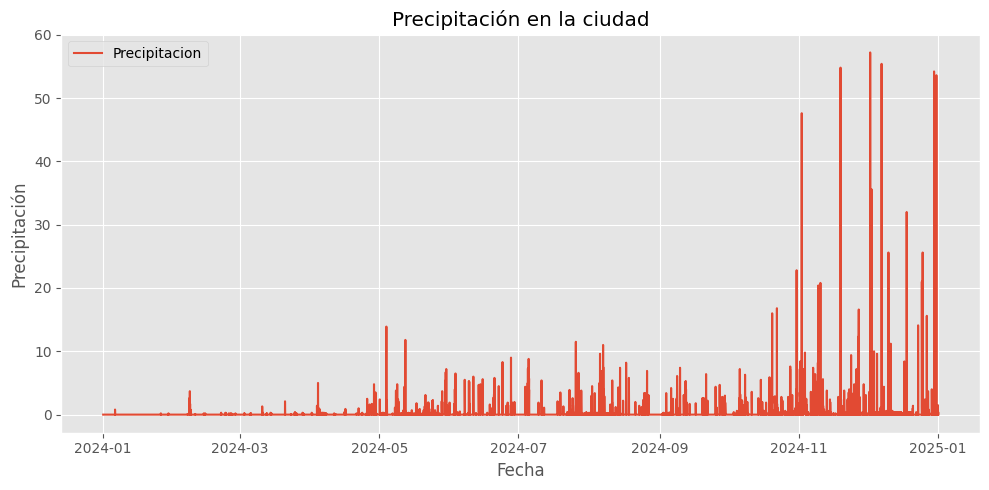

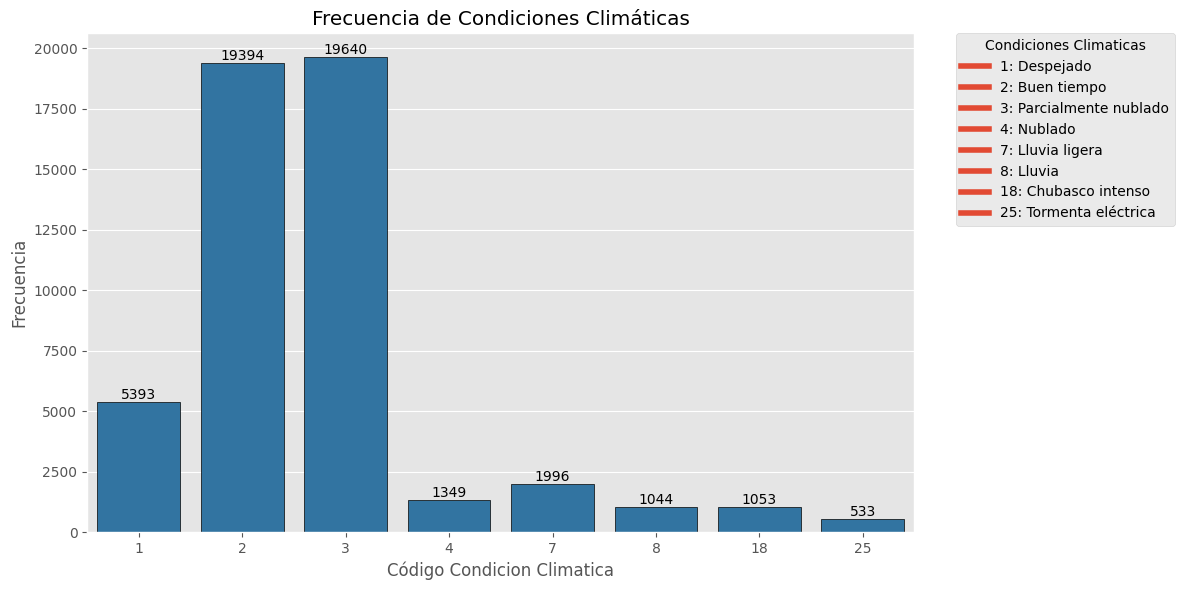

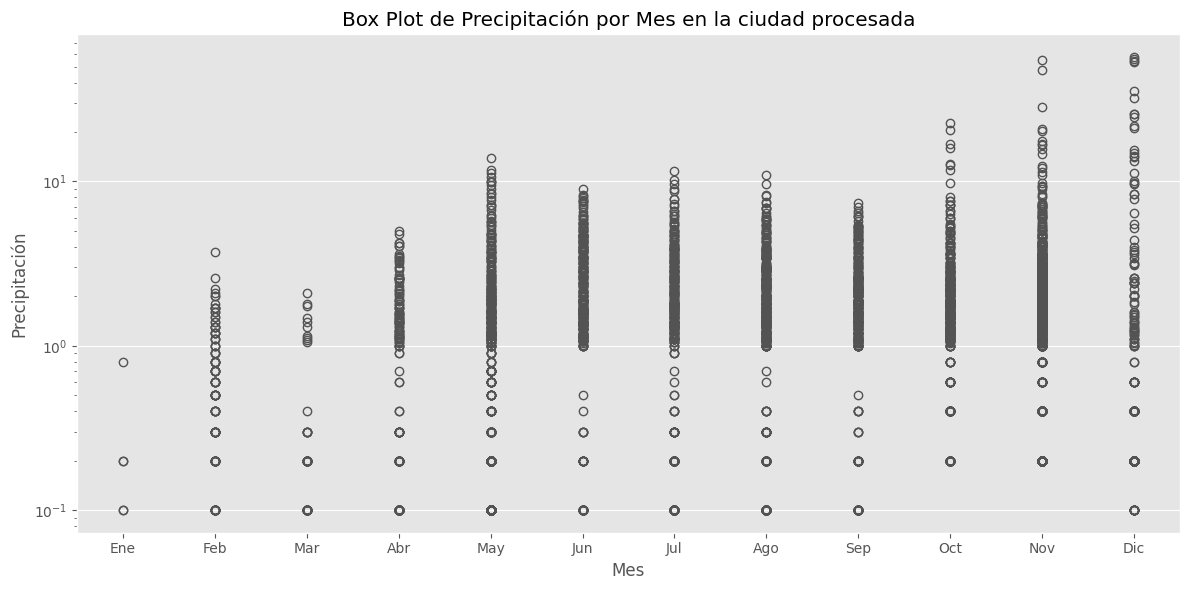


 Estadísticas de precipitación:

• Media: 0.14
• Mediana: 0.00
• Moda: 0.0
• Mínimo: 0.0 el 2024-01-01
• Máximo: 57.2 el 2024-12-02



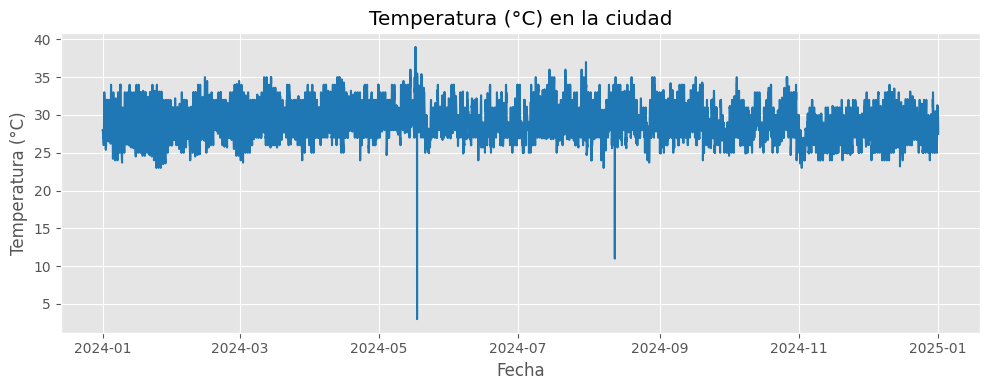

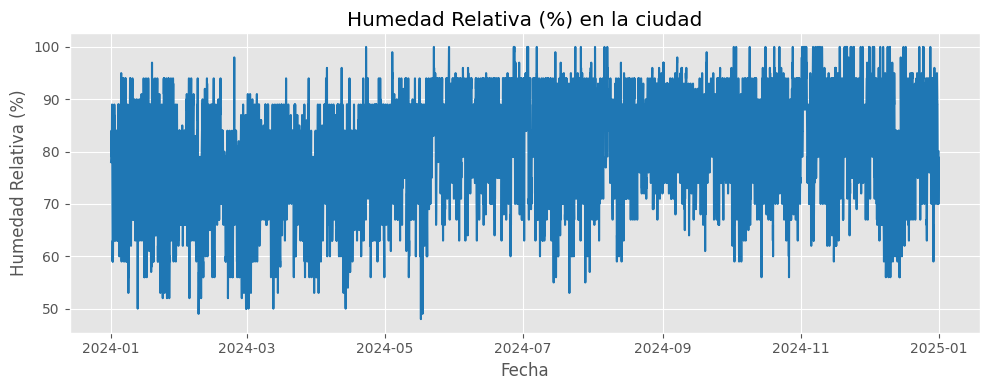

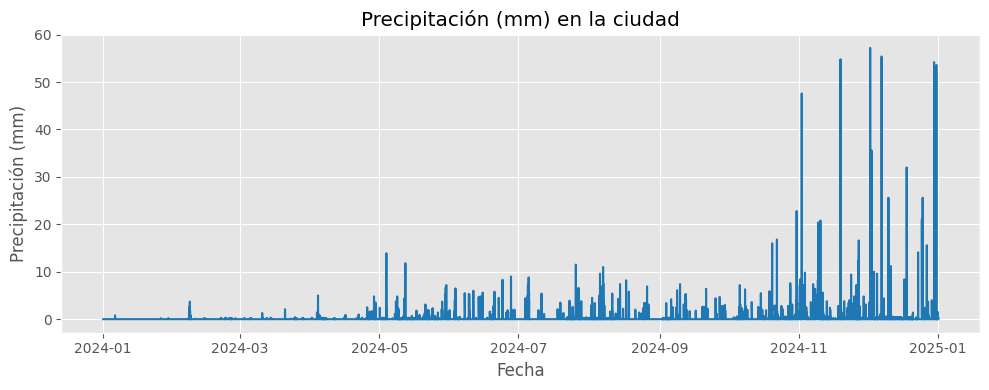

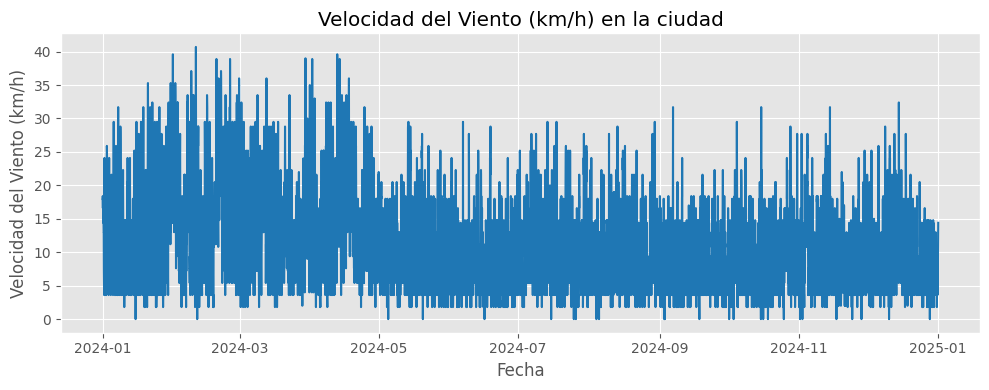


>>> Correlaciones entre columnas: ['temp', 'rhum', 'precipitacion', 'wspd']



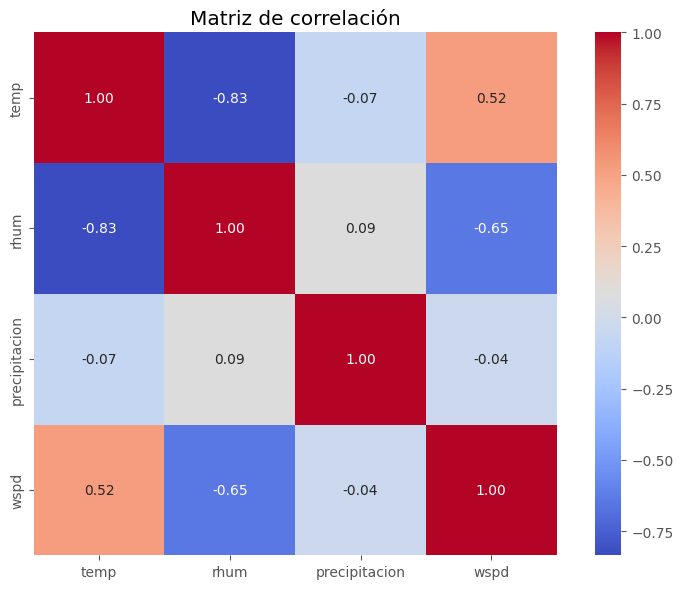

• Correlación entre 'temp' y 'rhum': -0.83 → Fuerte relación negativa.
• Correlación entre 'temp' y 'precipitacion': -0.07 → Relación insignificante.
• Correlación entre 'temp' y 'wspd': 0.52 → Relación moderada positiva.
• Correlación entre 'rhum' y 'precipitacion': 0.09 → Relación insignificante.
• Correlación entre 'rhum' y 'wspd': -0.65 → Relación moderada negativa.
• Correlación entre 'precipitacion' y 'wspd': -0.04 → Relación insignificante.


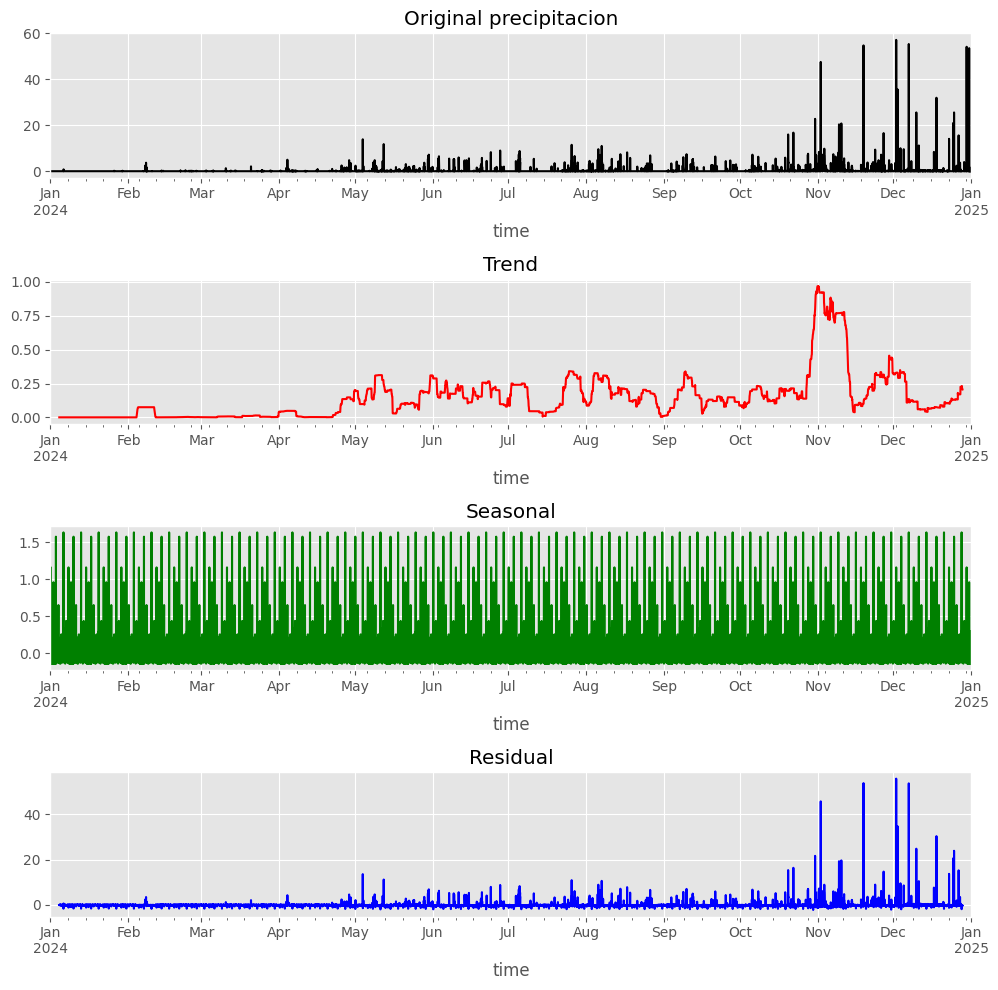

In [63]:
df_ciudad = preprocesar_ciudad('CARTAGENA DE INDIAS')
analizar_ciudad(df_ciudad)
barplot_coco_frecuencia(df_ciudad)
boxplot_mes_ciudad(df_ciudad)
estadisticas_precipitacion(df_ciudad)
analisis_temporal(df_ciudad)
columnas_interes = ["temp", "rhum", "precipitacion", "wspd"]
correlaciones_ciudad(df_ciudad, columnas_interes)
trend1 , seasonal1, residual1 = descompose_time_series(df_ciudad['precipitacion'],1008)

# Análisis Soledad


>>> Resumen del DataFrame original para SOLEDAD:

+-------------------+------------------+------------------+-----------------+-----+------------------+------------------+----+------------------+
|               time|              temp|              dwpt|             rhum| wdir|              wspd|              pres|coco|     precipitacion|
+-------------------+------------------+------------------+-----------------+-----+------------------+------------------+----+------------------+
|2024-07-03 21:20:00|29.466666666666665|26.933333333333334|87.33333333333333|320.0|10.466666666666667|1008.1999999999999| 4.0|1.4333333333333336|
|2024-07-03 21:30:00|              29.1|              26.9|             89.0|315.0|               9.2|           1008.15| 4.0|               1.6|
|2024-07-03 21:40:00|28.733333333333334|26.866666666666667|90.66666666666667|310.0| 7.933333333333334|            1008.1| 4.0|1.7666666666666668|
|2024-07-03 21:50:00|28.366666666666667|26.833333333333336|92.33333333333

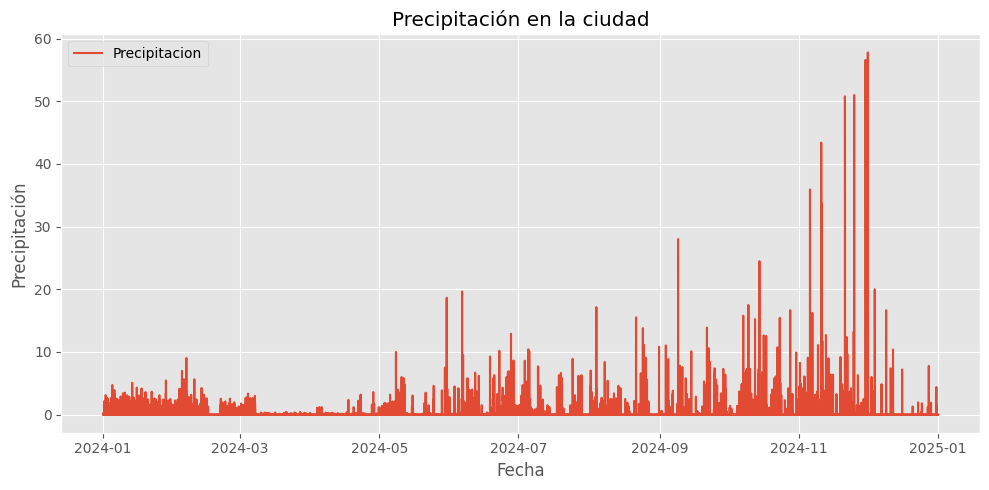

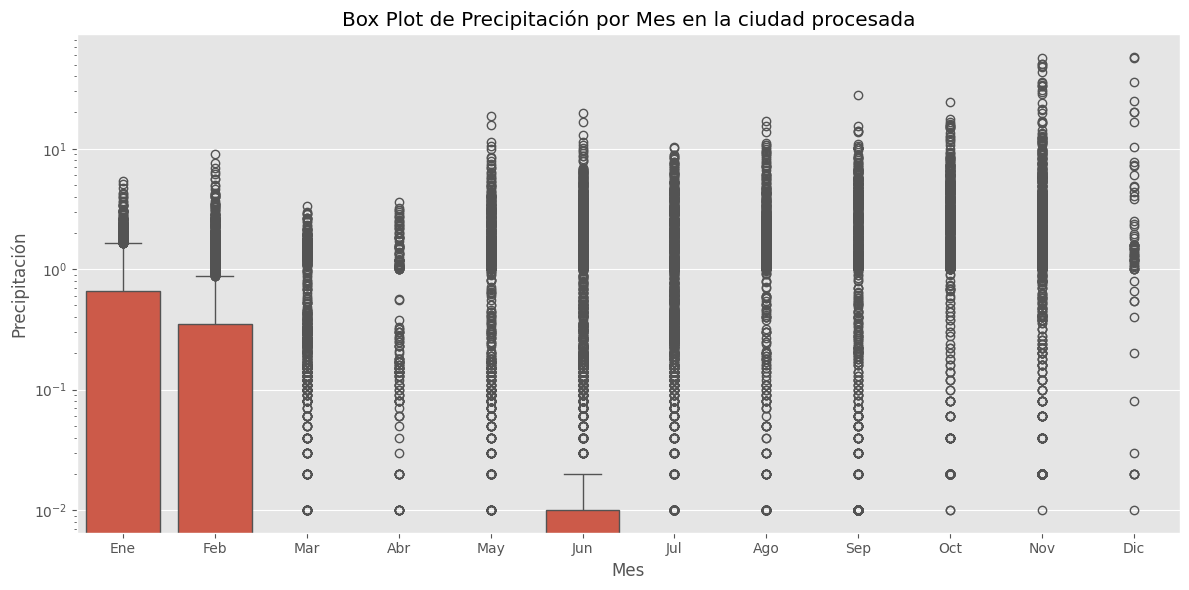

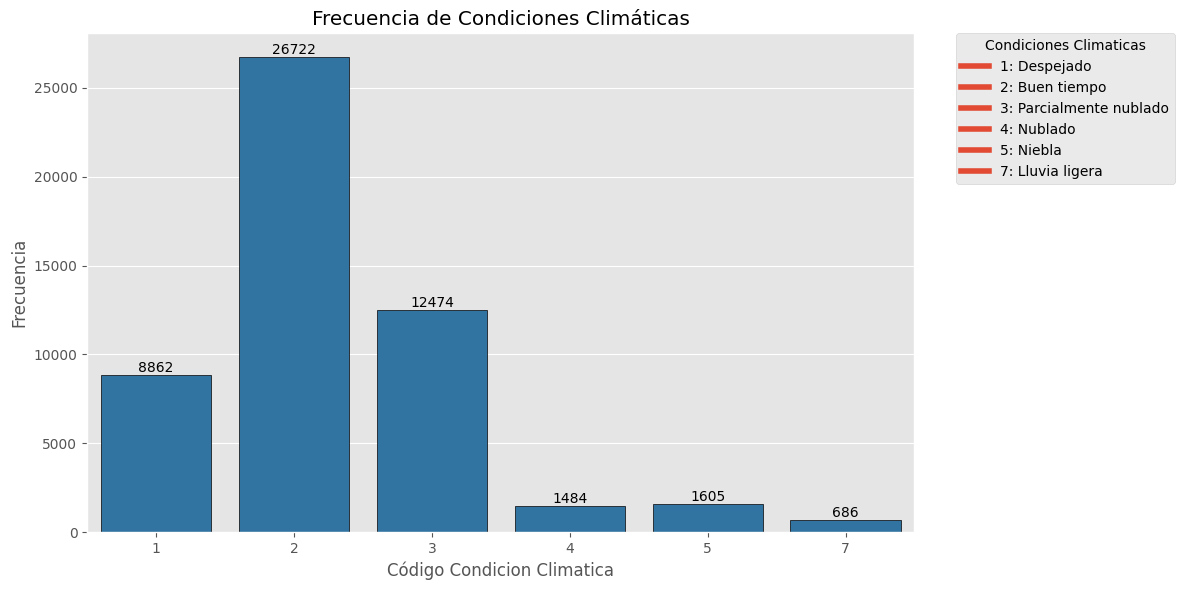


 Estadísticas de precipitación:

• Media: 0.28
• Mediana: 0.00
• Moda: 0.0
• Mínimo: 0.0 el 2024-07-04
• Máximo: 57.8 el 2024-12-01



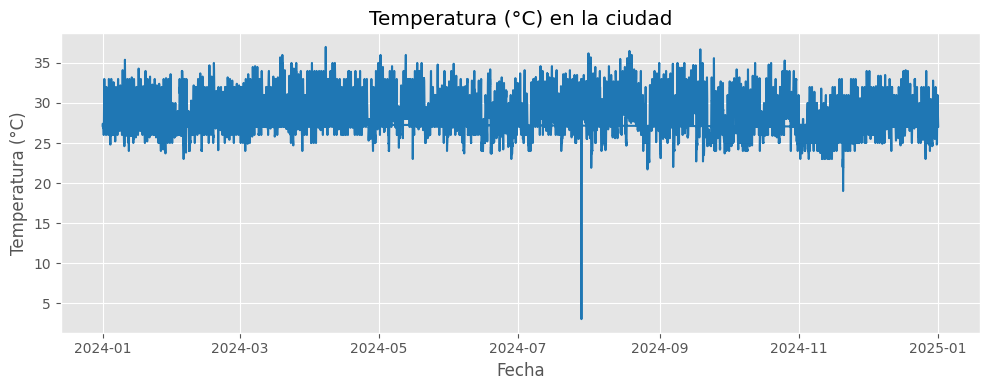

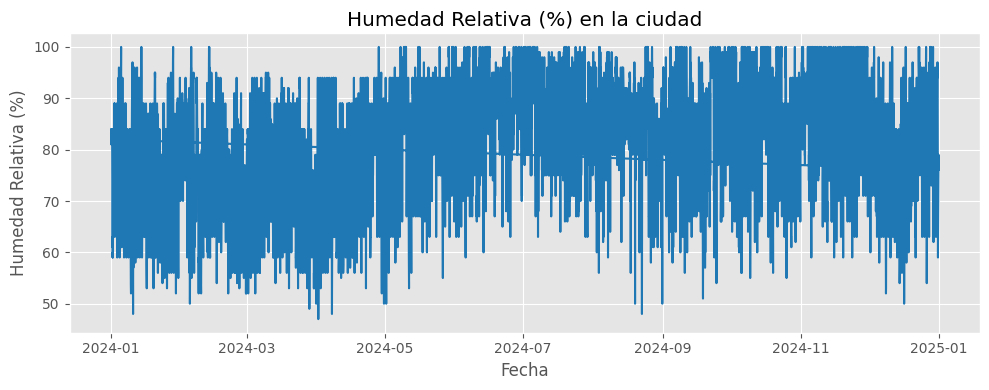

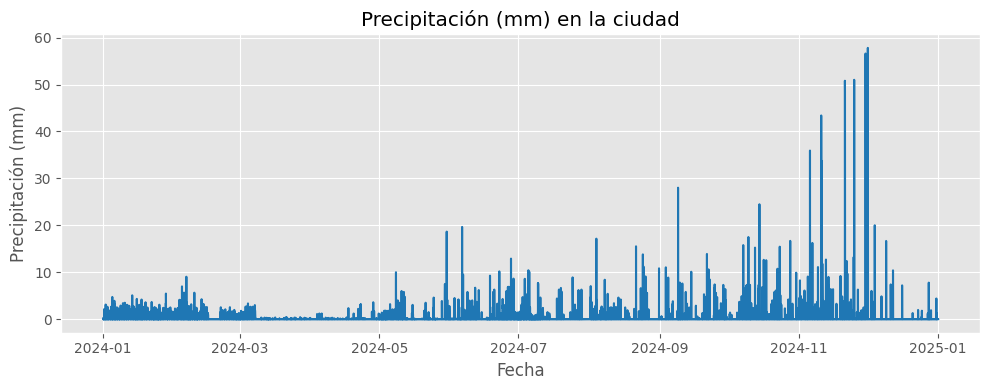

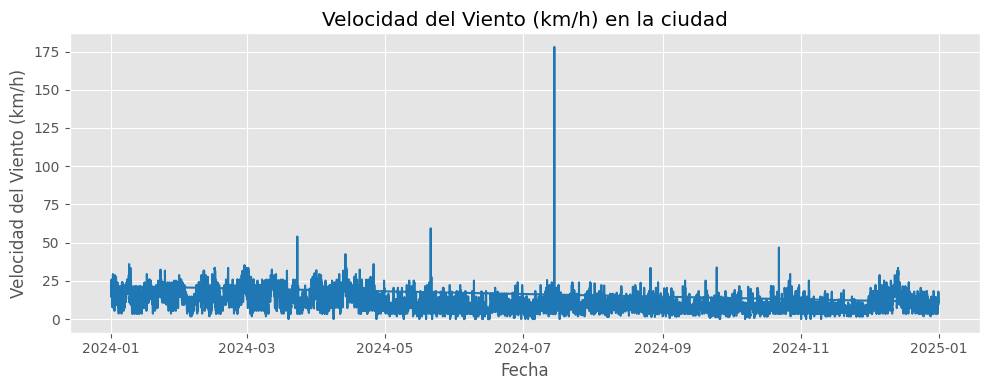


>>> Correlaciones entre columnas: ['temp', 'rhum', 'precipitacion', 'wspd']



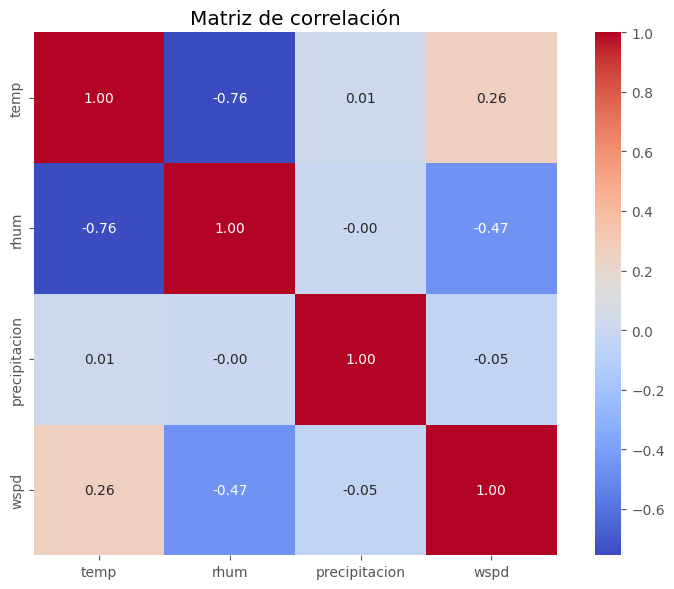

• Correlación entre 'temp' y 'rhum': -0.76 → Fuerte relación negativa.
• Correlación entre 'temp' y 'precipitacion': 0.01 → Relación insignificante.
• Correlación entre 'temp' y 'wspd': 0.26 → Relación insignificante.
• Correlación entre 'rhum' y 'precipitacion': -0.00 → Relación insignificante.
• Correlación entre 'rhum' y 'wspd': -0.47 → Relación débil negativa.
• Correlación entre 'precipitacion' y 'wspd': -0.05 → Relación insignificante.


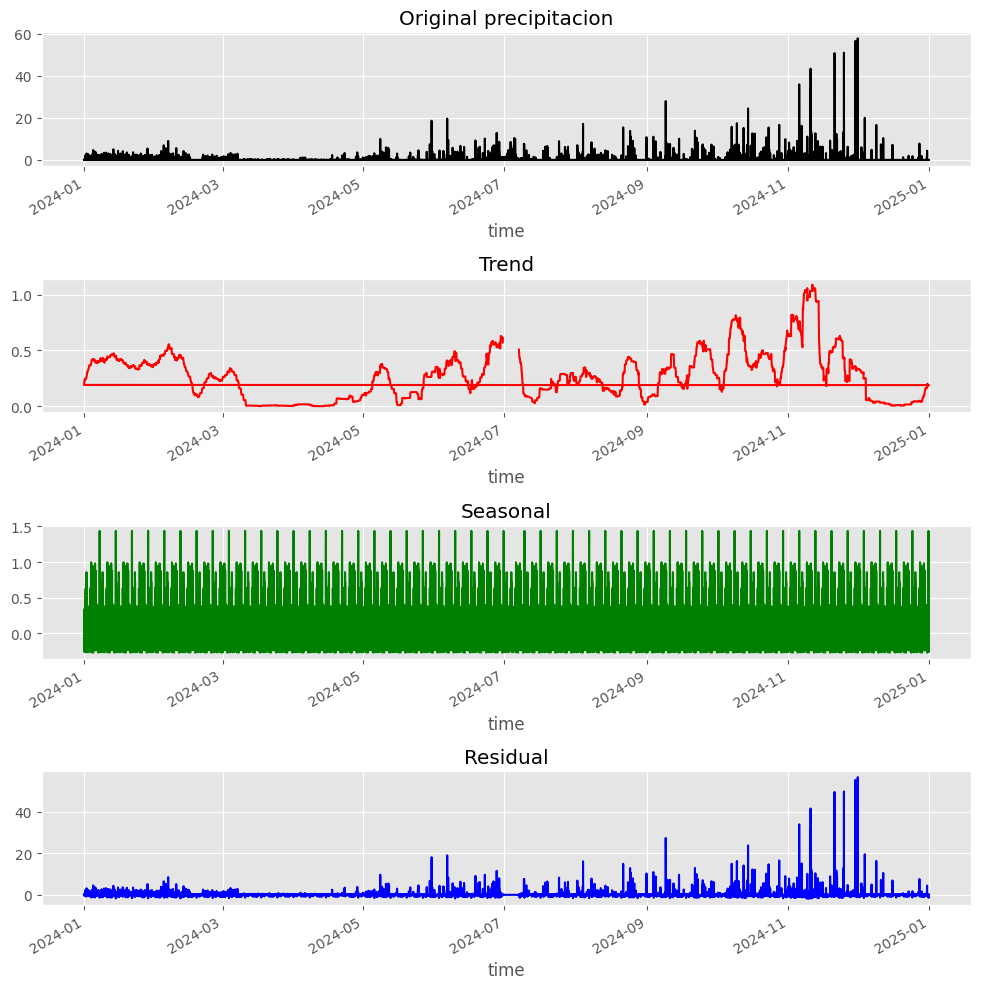

In [61]:
df_ciudad = preprocesar_ciudad('SOLEDAD')
analizar_ciudad(df_ciudad)
boxplot_mes_ciudad(df_ciudad)
barplot_coco_frecuencia(df_ciudad)
estadisticas_precipitacion(df_ciudad)
analisis_temporal(df_ciudad)
columnas_interes = ["temp", "rhum", "precipitacion", "wspd"]
correlaciones_ciudad(df_ciudad, columnas_interes)
trend1 , seasonal1, residual1 = descompose_time_series(df_ciudad['precipitacion'],1008)

# Análisis Valledupar


>>> Resumen del DataFrame original para VALLEDUPAR:

+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+-------------+
|               time|              temp|              dwpt|              rhum|              wdir|              wspd|              pres|             coco|precipitacion|
+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+-------------+
|2024-07-03 21:20:00|31.533333333333335|24.400000000000002| 64.33333333333333|233.33333333333334|10.333333333333334|1009.4666666666667|6.333333333333333|          0.0|
|2024-07-03 21:30:00|             31.65|24.450000000000003|              64.0|             240.0|10.100000000000001|           1009.35|              5.5|          0.0|
|2024-07-03 21:40:00|31.766666666666666|              24.5|63.666666666666664|246.66666666666666| 9.866666

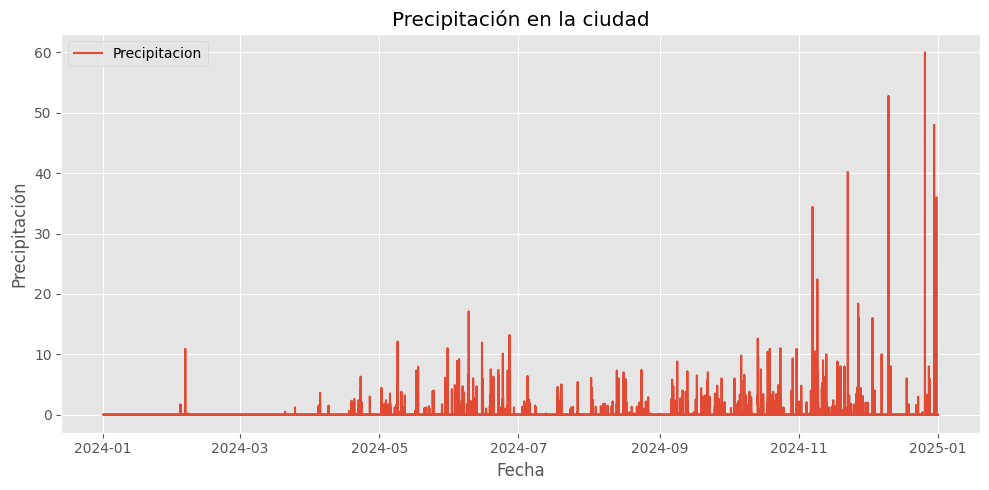

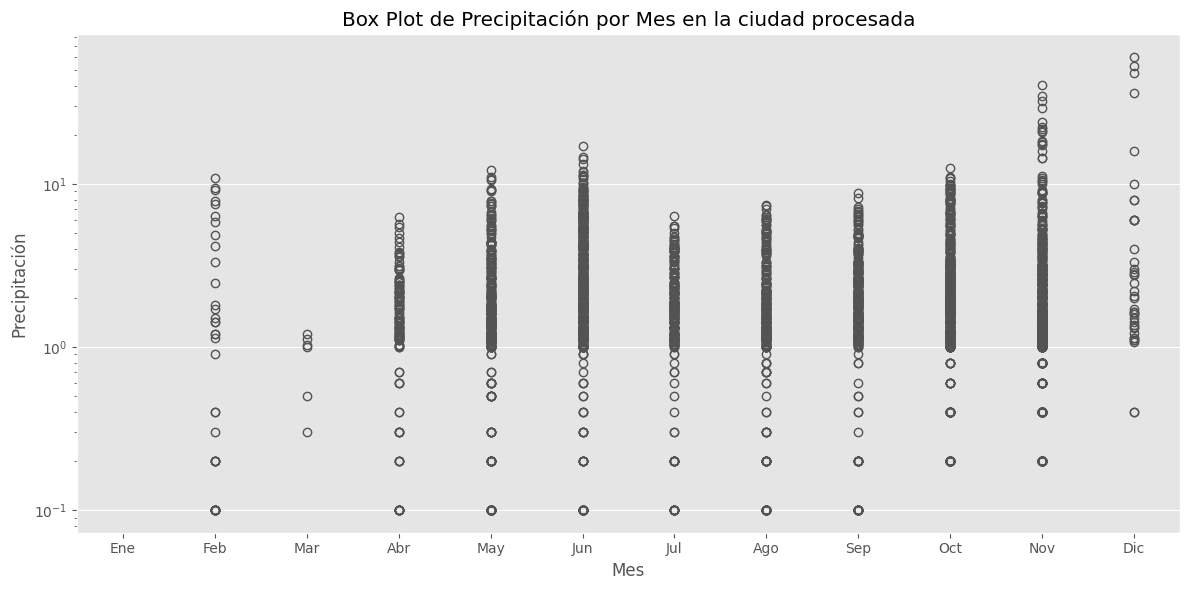

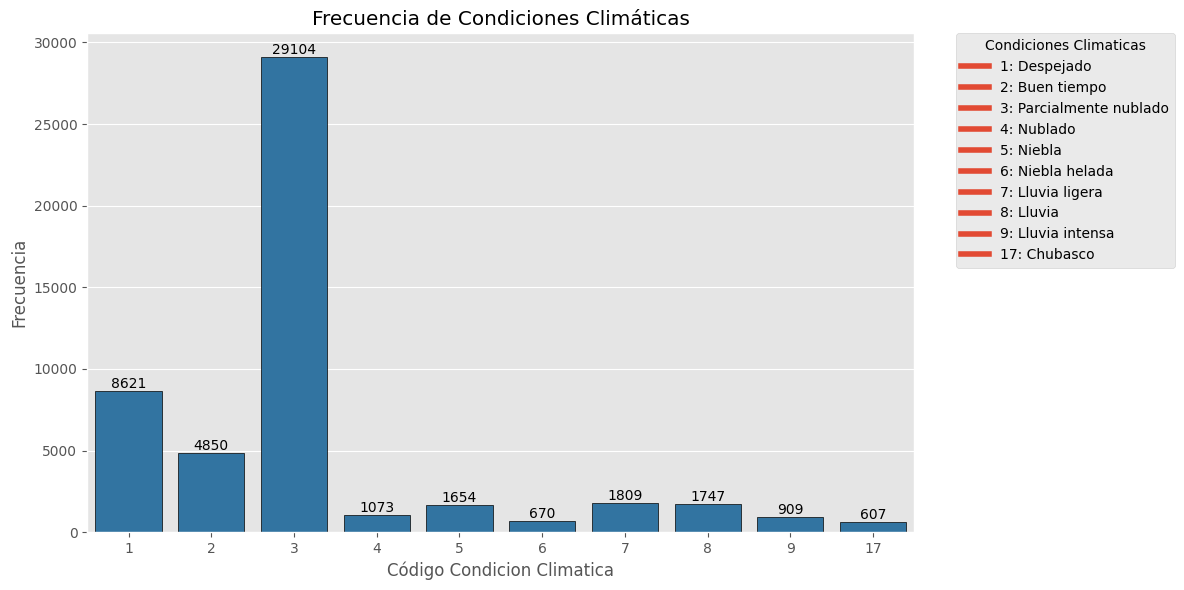


 Estadísticas de precipitación:

• Media: 0.14
• Mediana: 0.00
• Moda: 0.0
• Mínimo: 0.0 el 2024-07-03
• Máximo: 60.0 el 2024-12-26



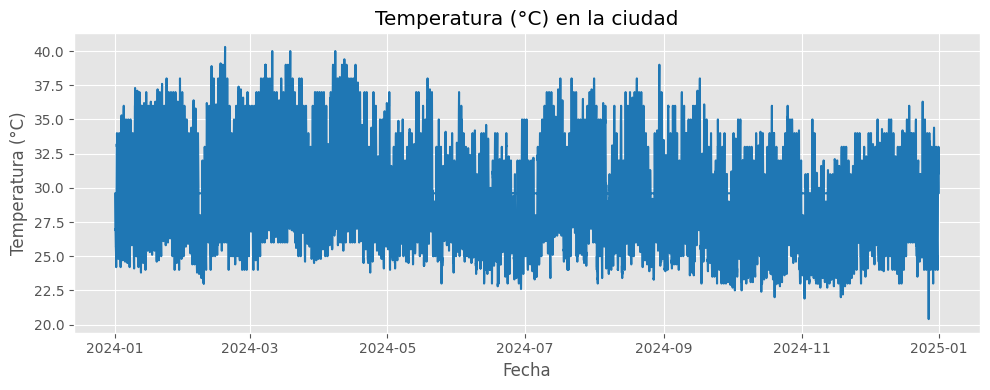

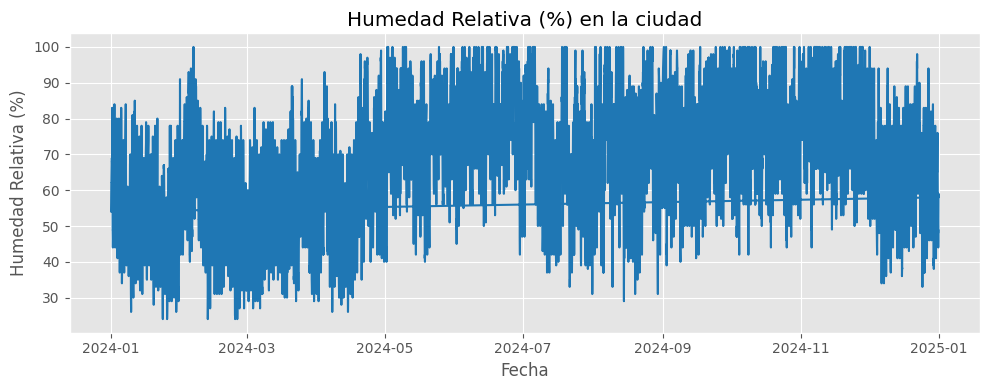

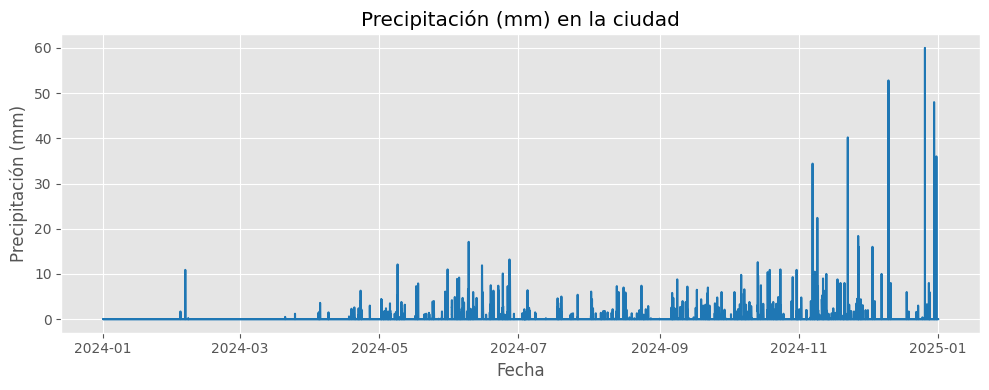

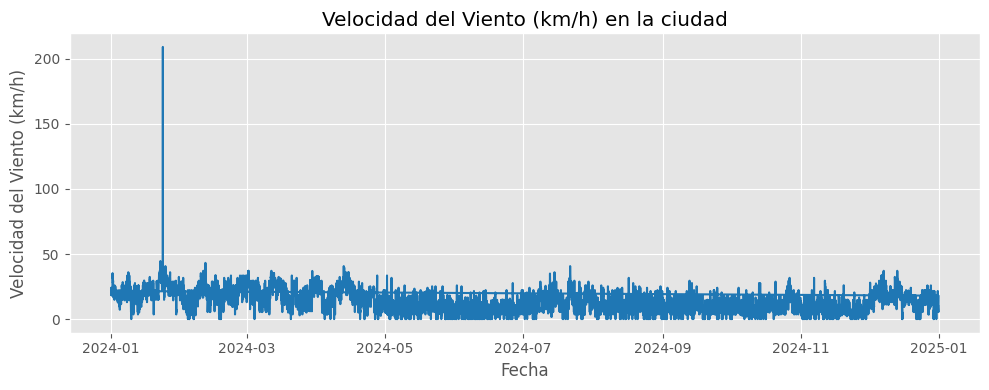


>>> Correlaciones entre columnas: ['temp', 'rhum', 'precipitacion', 'wspd']



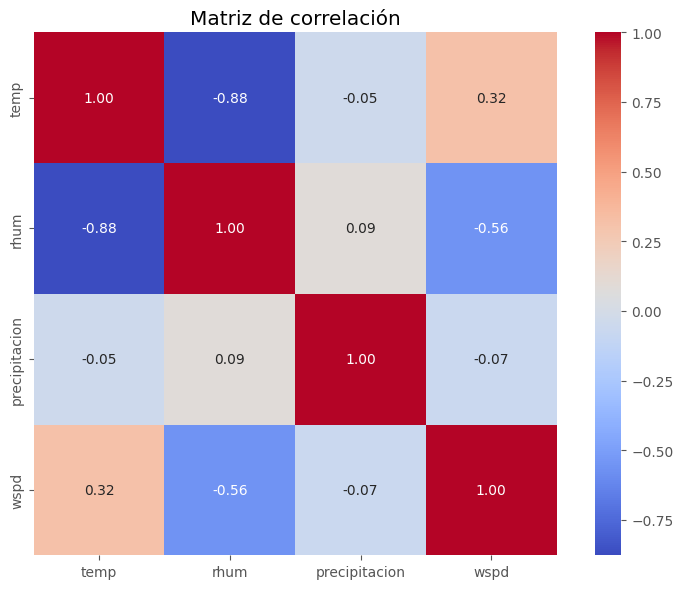

• Correlación entre 'temp' y 'rhum': -0.88 → Fuerte relación negativa.
• Correlación entre 'temp' y 'precipitacion': -0.05 → Relación insignificante.
• Correlación entre 'temp' y 'wspd': 0.32 → Relación débil positiva.
• Correlación entre 'rhum' y 'precipitacion': 0.09 → Relación insignificante.
• Correlación entre 'rhum' y 'wspd': -0.56 → Relación moderada negativa.
• Correlación entre 'precipitacion' y 'wspd': -0.07 → Relación insignificante.


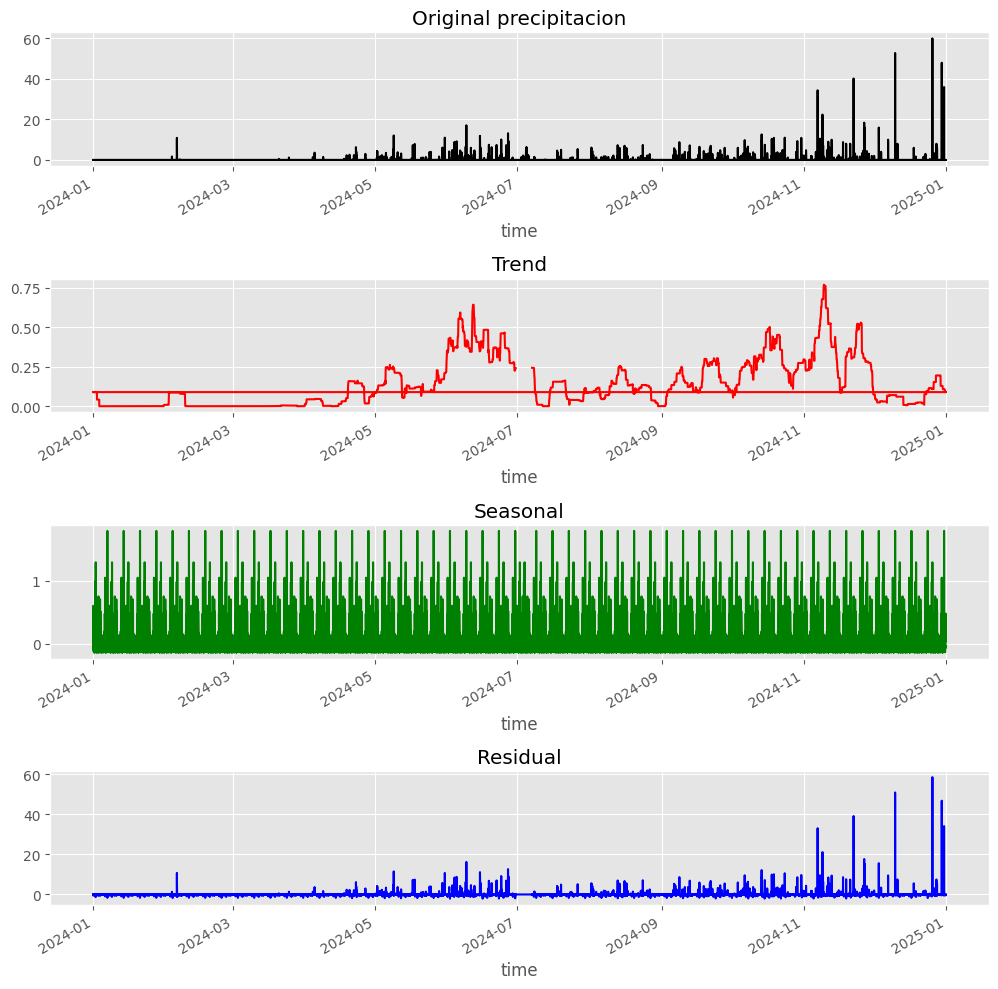

In [62]:
df_ciudad = preprocesar_ciudad('VALLEDUPAR')
analizar_ciudad(df_ciudad)
boxplot_mes_ciudad(df_ciudad)
barplot_coco_frecuencia(df_ciudad)
estadisticas_precipitacion(df_ciudad)
analisis_temporal(df_ciudad)
columnas_interes = ["temp", "rhum", "precipitacion", "wspd"]
correlaciones_ciudad(df_ciudad, columnas_interes)
trend1 , seasonal1, residual1 = descompose_time_series(df_ciudad['precipitacion'],1008)

# Análisis Bogota D.C


>>> Resumen del DataFrame original para BOGOTA D.C:

+-------------------+------------------+------------------+-----------------+----+------------------+------+----+-------------+
|               time|              temp|              dwpt|             rhum|wdir|              wspd|  pres|coco|precipitacion|
+-------------------+------------------+------------------+-----------------+----+------------------+------+----+-------------+
|2024-07-03 21:20:00|17.733333333333334|12.466666666666669|73.66666666666667|30.0|12.733333333333334|1024.0| 7.0|          0.0|
|2024-07-03 21:30:00|             17.55|12.450000000000001|             74.5|30.0|              11.9|1024.0| 7.0|          0.0|
|2024-07-03 21:40:00|17.366666666666667|12.433333333333334|75.33333333333333|30.0|11.066666666666666|1024.0| 7.0|          0.1|
|2024-07-03 21:50:00|17.183333333333334|12.416666666666668|76.16666666666667|30.0|10.233333333333334|1024.0| 7.0|          0.1|
|2024-07-03 22:00:00|              17.0|          

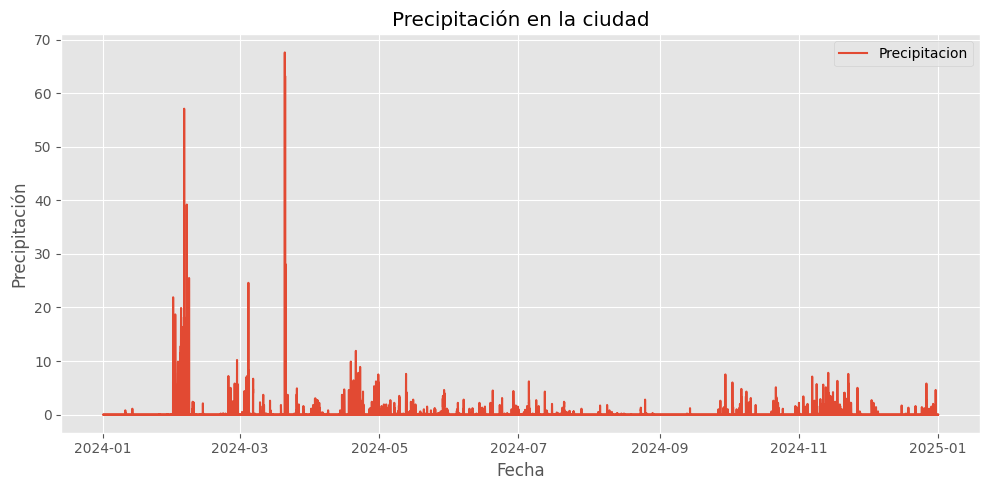

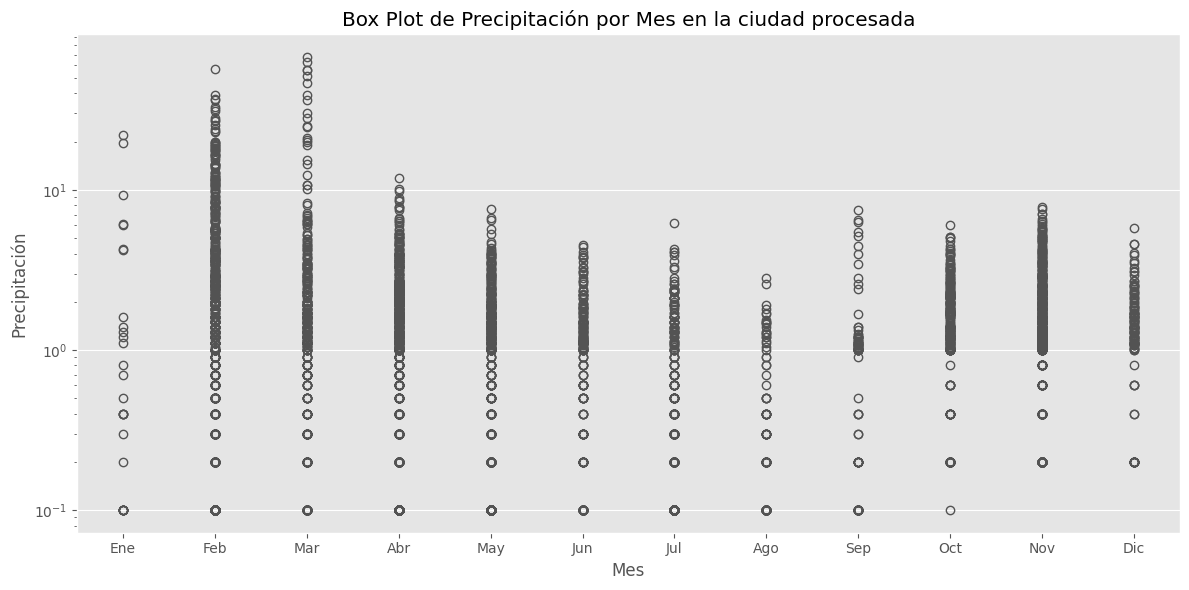

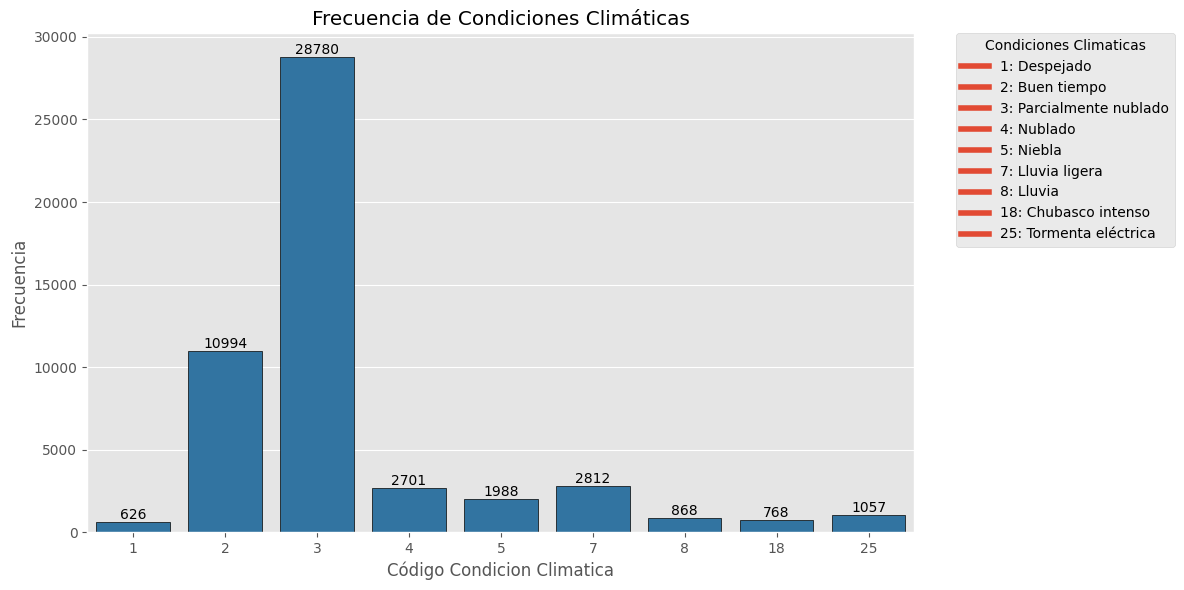


 Estadísticas de precipitación:

• Media: 0.14
• Mediana: 0.00
• Moda: 0.0
• Mínimo: 0.0 el 2024-07-03
• Máximo: 67.6000000000001 el 2024-03-20



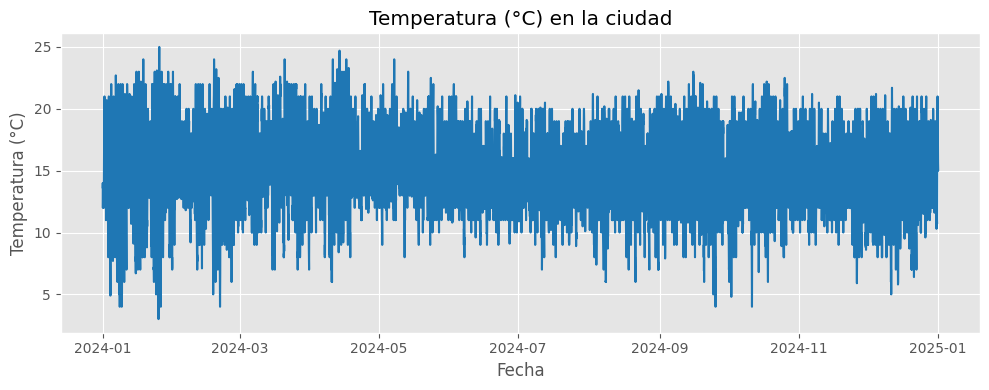

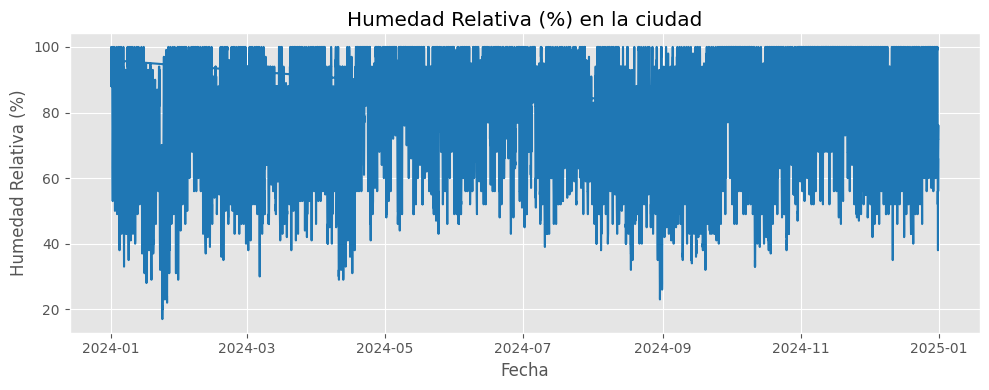

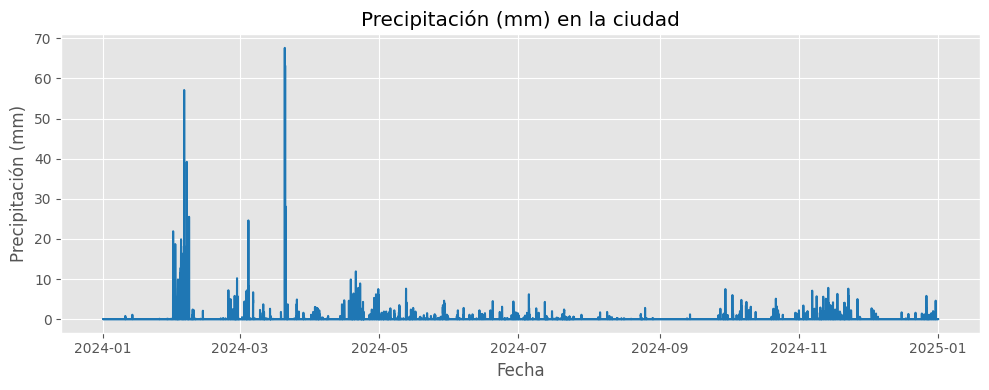

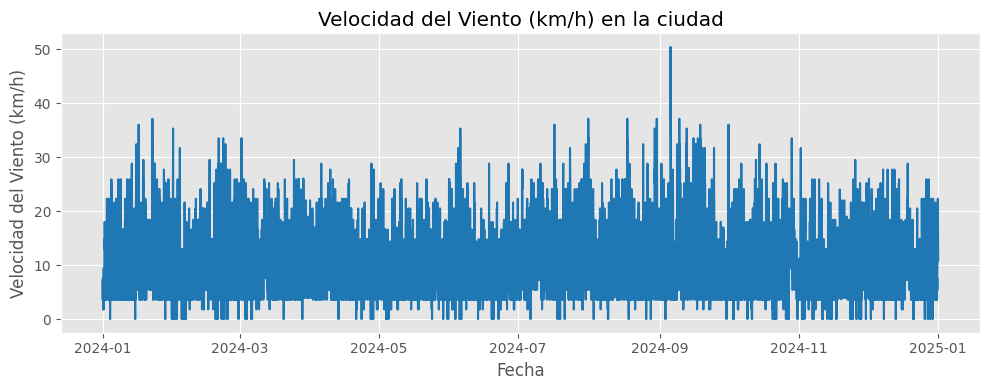


>>> Correlaciones entre columnas: ['temp', 'rhum', 'precipitacion', 'wspd']



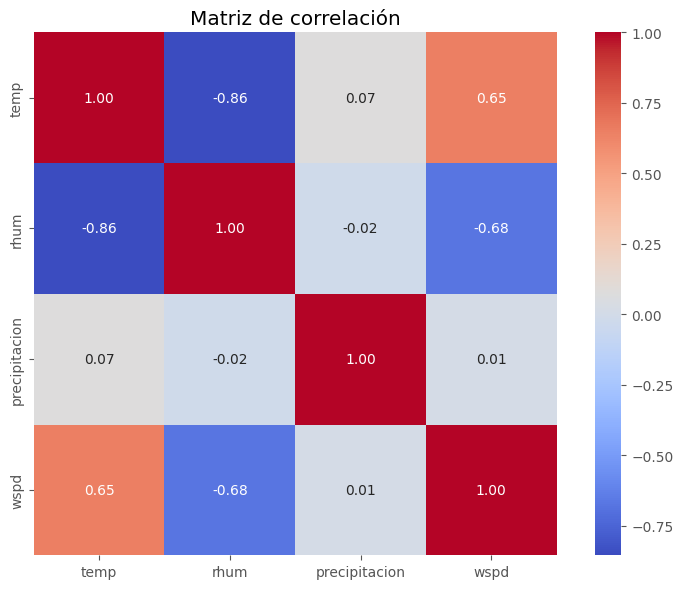

• Correlación entre 'temp' y 'rhum': -0.86 → Fuerte relación negativa.
• Correlación entre 'temp' y 'precipitacion': 0.07 → Relación insignificante.
• Correlación entre 'temp' y 'wspd': 0.65 → Relación moderada positiva.
• Correlación entre 'rhum' y 'precipitacion': -0.02 → Relación insignificante.
• Correlación entre 'rhum' y 'wspd': -0.68 → Relación moderada negativa.
• Correlación entre 'precipitacion' y 'wspd': 0.01 → Relación insignificante.


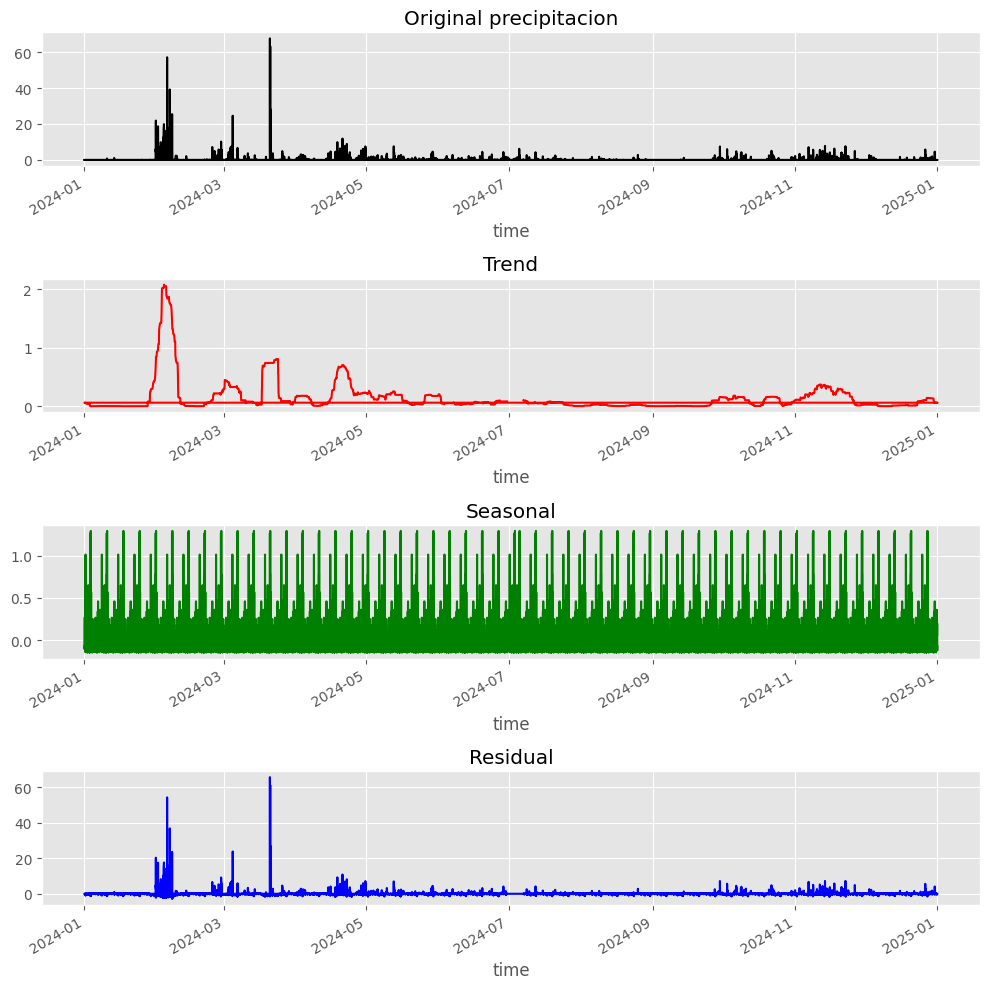

In [64]:
df_ciudad = preprocesar_ciudad('BOGOTA D.C')
analizar_ciudad(df_ciudad)
boxplot_mes_ciudad(df_ciudad)
barplot_coco_frecuencia(df_ciudad)
estadisticas_precipitacion(df_ciudad)
analisis_temporal(df_ciudad)
columnas_interes = ["temp", "rhum", "precipitacion", "wspd"]
correlaciones_ciudad(df_ciudad, columnas_interes)
trend1 , seasonal1, residual1 = descompose_time_series(df_ciudad['precipitacion'],1008)

# Análisis Neiva


>>> Resumen del DataFrame original para NEIVA:

+-------------------+------------------+------------------+------------------+-----+-----------------+------+----+-------------+
|               time|              temp|              dwpt|              rhum| wdir|             wspd|  pres|coco|precipitacion|
+-------------------+------------------+------------------+------------------+-----+-----------------+------+----+-------------+
|2024-07-03 21:20:00|30.266666666666666|              21.4|55.666666666666664|170.0|9.733333333333334|1009.0| 3.0|          0.0|
|2024-07-03 21:30:00|              30.2|21.299999999999997|              55.5|200.0|              9.2|1009.0| 3.0|          0.0|
|2024-07-03 21:40:00|30.133333333333333|              21.2|55.333333333333336|230.0|8.666666666666666|1009.0| 3.0|          0.0|
|2024-07-03 21:50:00|30.066666666666666|              21.1|55.166666666666664|260.0|8.133333333333333|1009.0| 3.0|          0.0|
|2024-07-03 22:00:00|              30.0|        

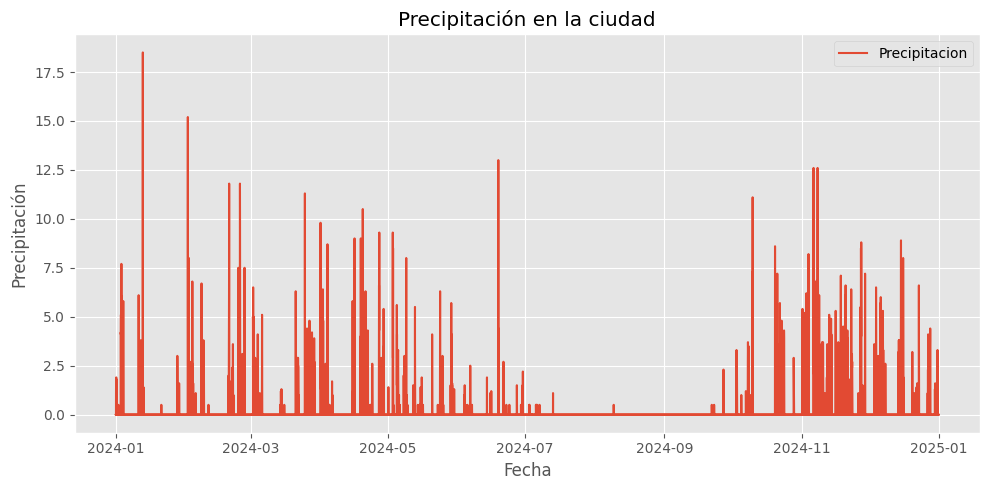

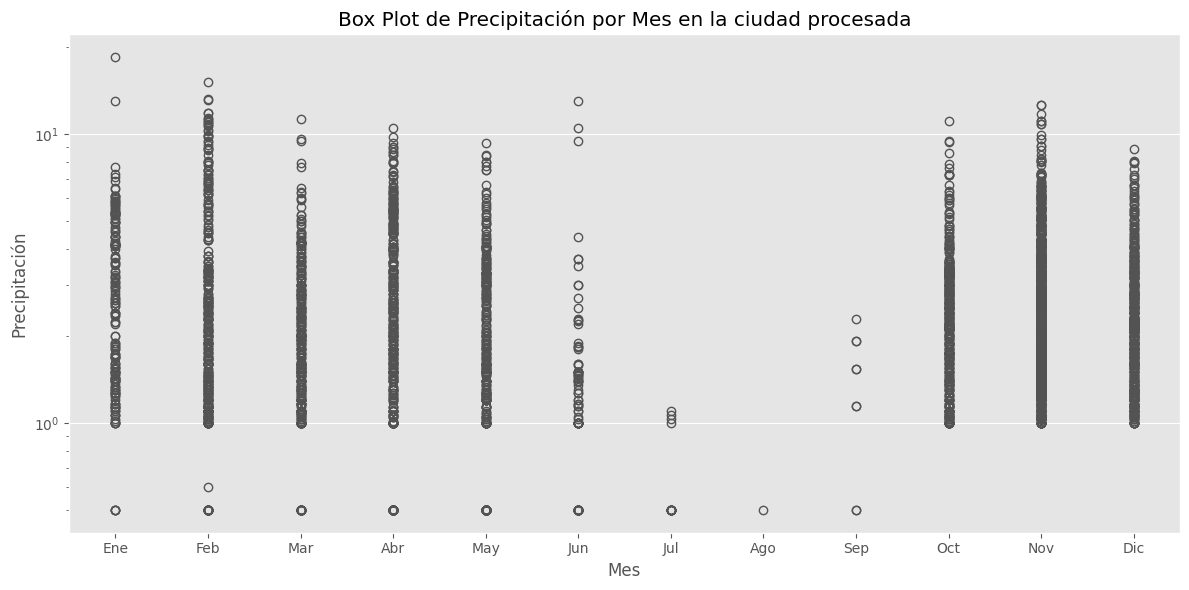

⚠️ Error procesando el DataFrame: name 'df' is not defined


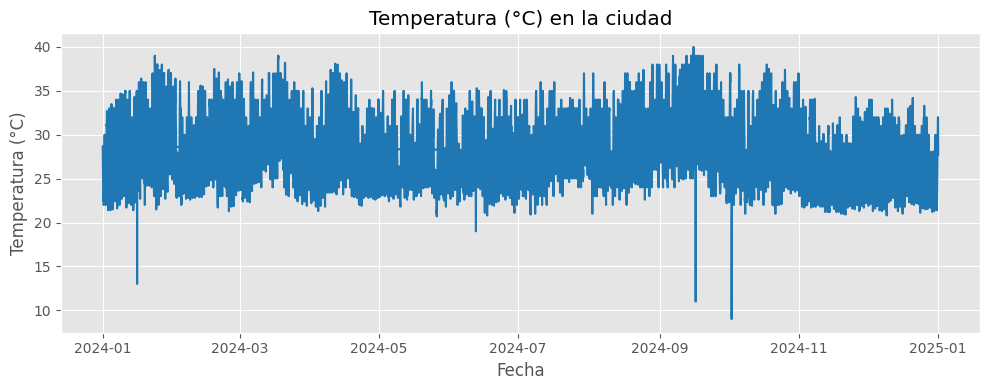

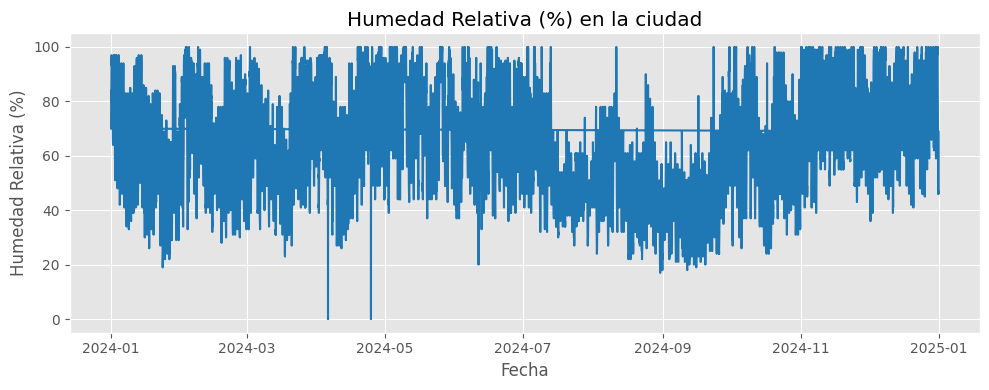

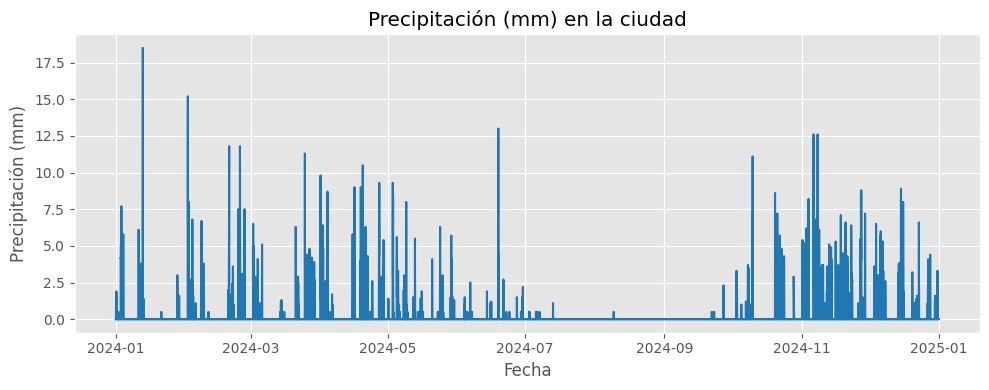

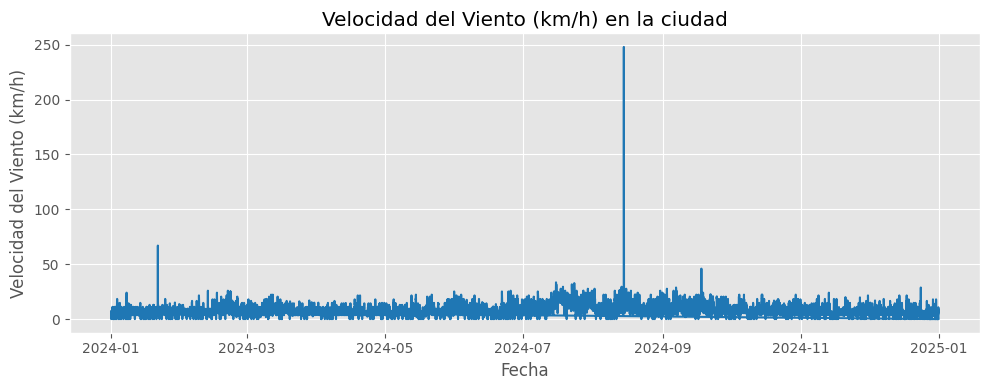


>>> Correlaciones entre columnas: ['temp', 'rhum', 'precipitacion', 'wspd']



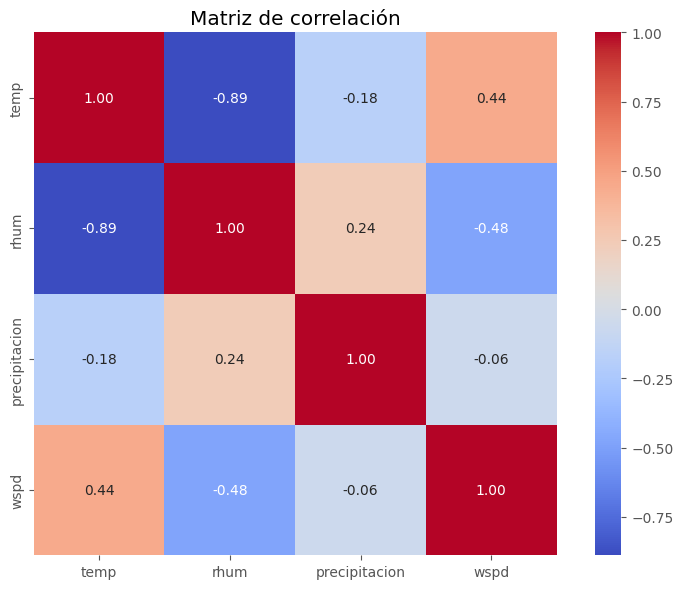

• Correlación entre 'temp' y 'rhum': -0.89 → Fuerte relación negativa.
• Correlación entre 'temp' y 'precipitacion': -0.18 → Relación insignificante.
• Correlación entre 'temp' y 'wspd': 0.44 → Relación débil positiva.
• Correlación entre 'rhum' y 'precipitacion': 0.24 → Relación insignificante.
• Correlación entre 'rhum' y 'wspd': -0.48 → Relación débil negativa.
• Correlación entre 'precipitacion' y 'wspd': -0.06 → Relación insignificante.


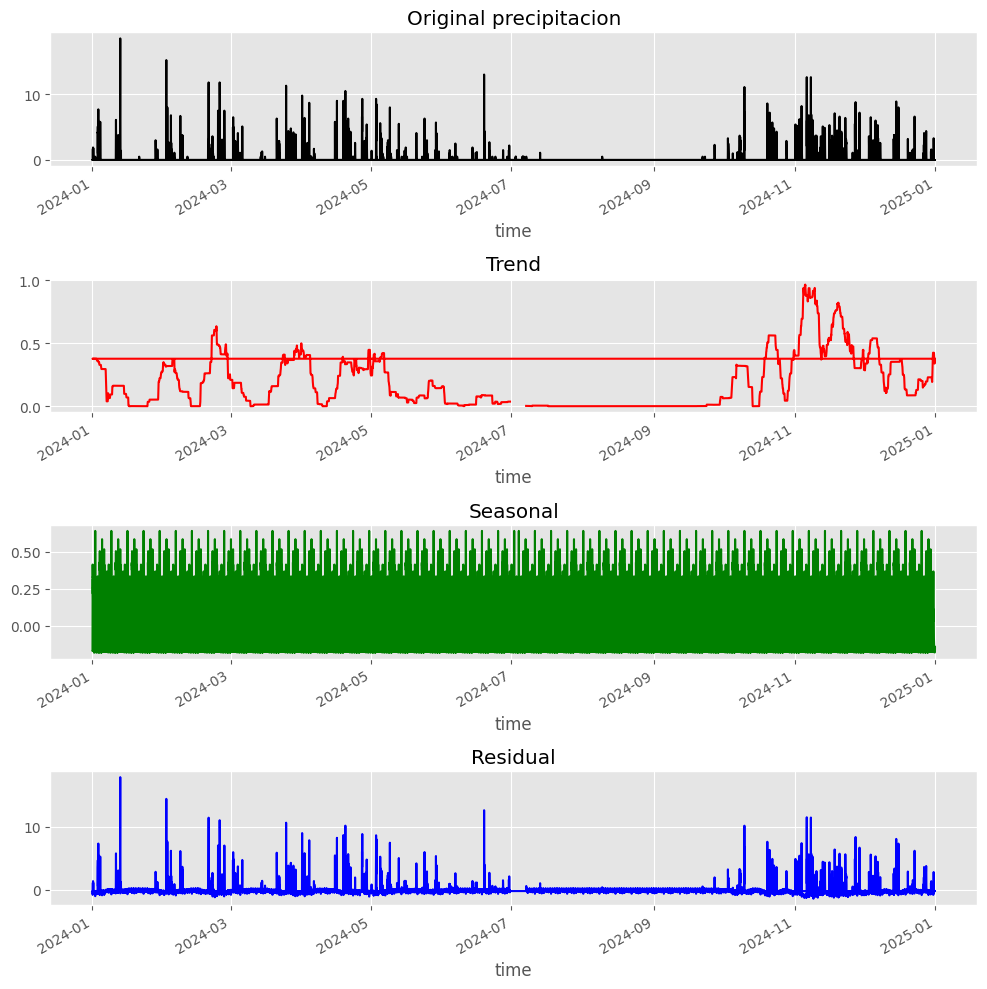

In [15]:
df_ciudad = preprocesar_ciudad('NEIVA')
analizar_ciudad(df_ciudad)
boxplot_mes_ciudad(df_ciudad)
barplot_coco_frecuencia(df_ciudad)
estadisticas_precipitacion(df_ciudad)
analisis_temporal(df_ciudad)
columnas_interes = ["temp", "rhum", "precipitacion", "wspd"]
correlaciones_ciudad(df_ciudad, columnas_interes)
trend1 , seasonal1, residual1 = descompose_time_series(df_ciudad['precipitacion'],1008)

# Análisis Riohacha


>>> Resumen del DataFrame original para RIOHACHA:

+-------------------+-----+------------------+----+-----------------+------------------+------+----+------------------+
|               time| temp|              dwpt|rhum|             wdir|              wspd|  pres|coco|     precipitacion|
+-------------------+-----+------------------+----+-----------------+------------------+------+----+------------------+
|2024-07-03 21:20:00| 26.9|              20.3|67.0|327.6666666666667|13.933333333333334|1008.0| 9.0| 5.033333333333333|
|2024-07-03 21:30:00|26.85|             20.25|67.0|            321.5|             14.05|1008.0| 9.0|              4.25|
|2024-07-03 21:40:00| 26.8|              20.2|67.0|315.3333333333333|14.166666666666666|1008.0| 9.0| 3.466666666666667|
|2024-07-03 21:50:00|26.75|20.150000000000002|67.0|309.1666666666667|14.283333333333333|1008.0| 9.0|2.6833333333333336|
|2024-07-03 22:00:00| 26.7|              20.1|67.0|            303.0|              14.4|1008.0| 9.0|        

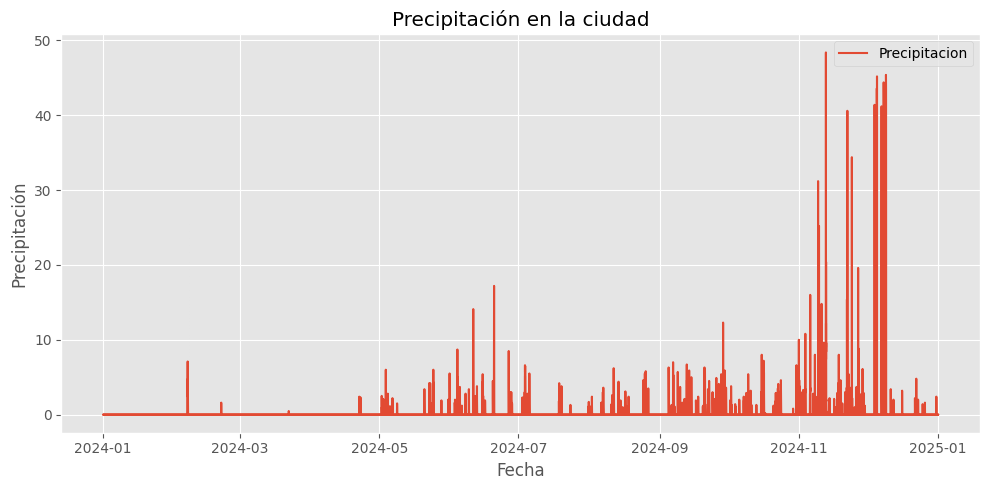

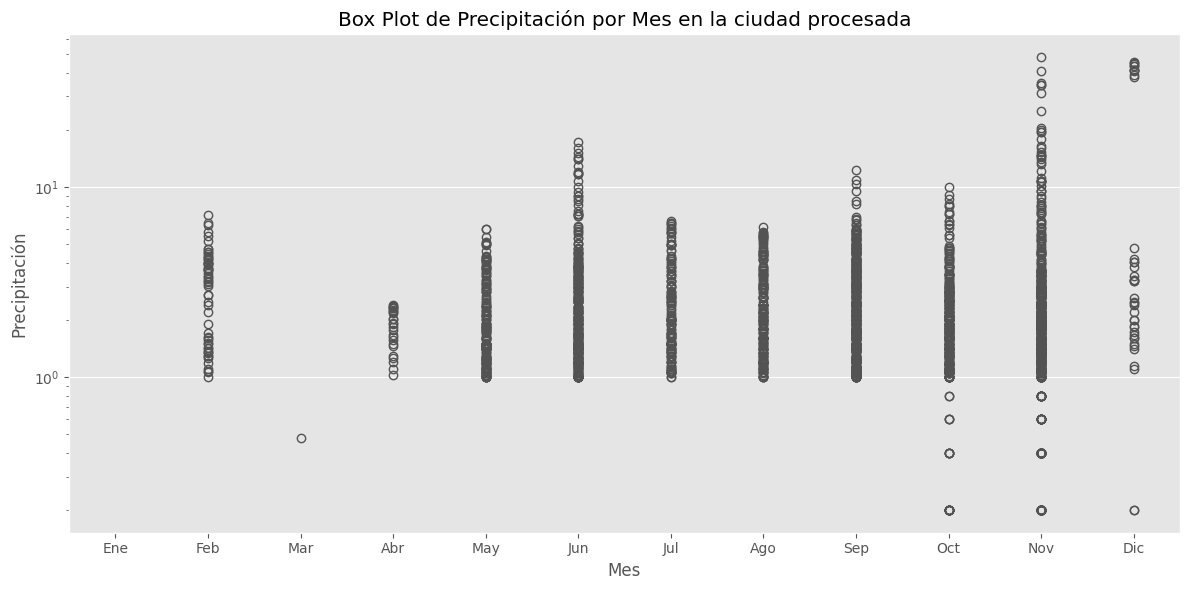

⚠️ Error procesando el DataFrame: name 'df' is not defined


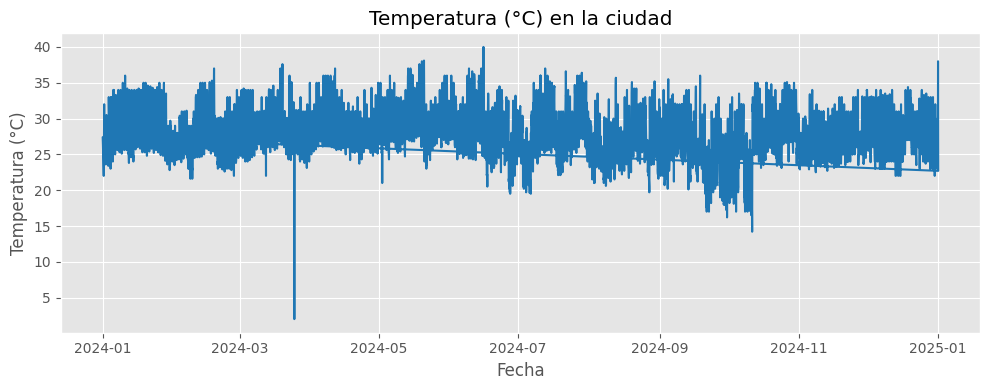

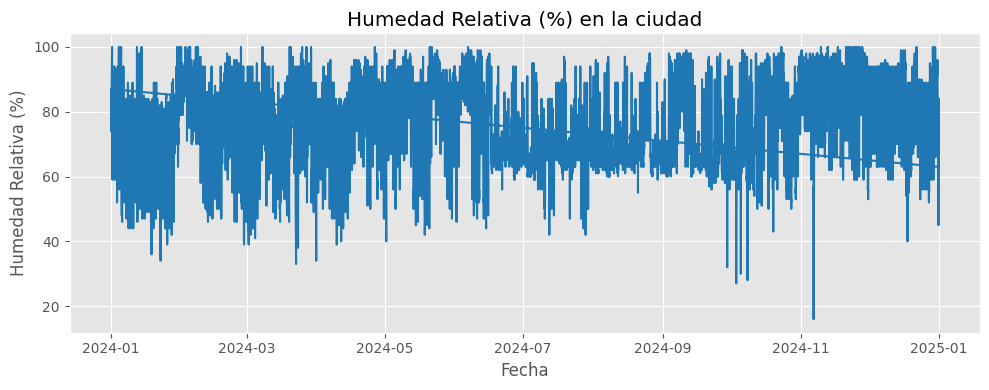

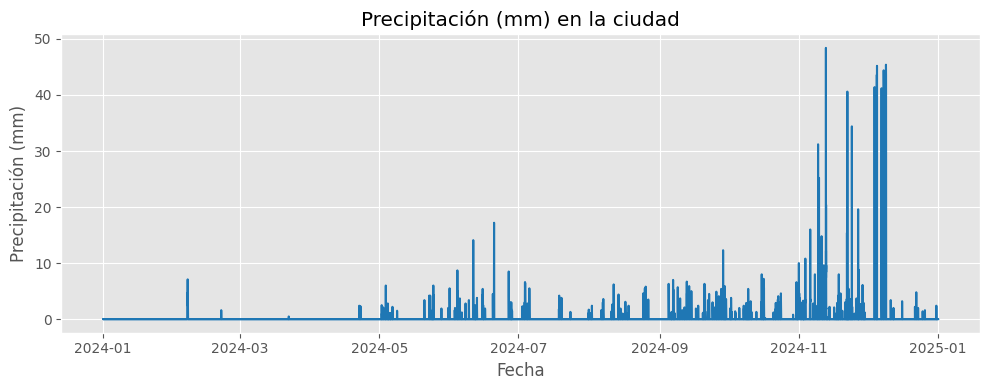

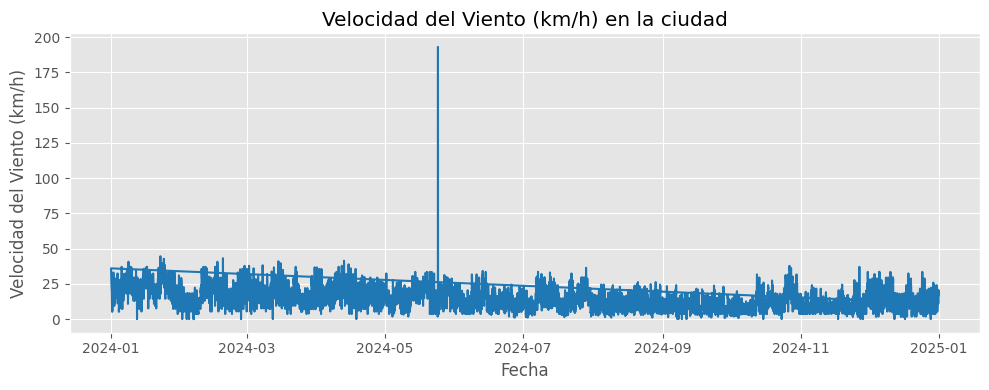


>>> Correlaciones entre columnas: ['temp', 'rhum', 'precipitacion', 'wspd']



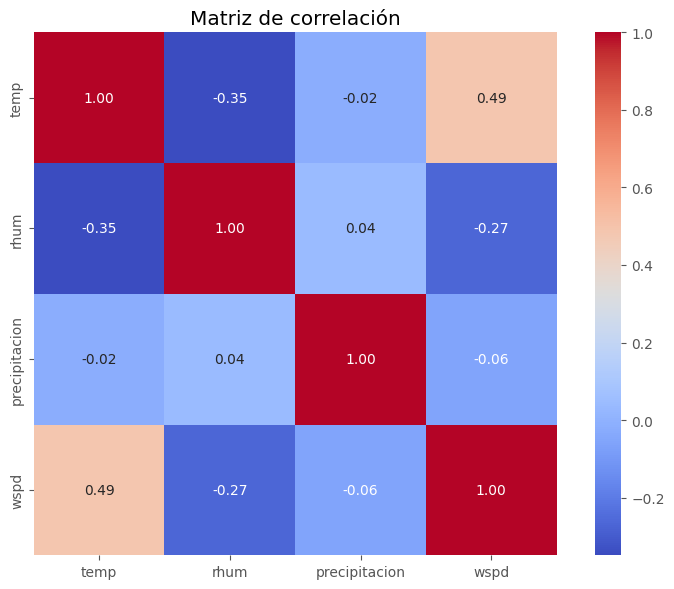

• Correlación entre 'temp' y 'rhum': -0.35 → Relación débil negativa.
• Correlación entre 'temp' y 'precipitacion': -0.02 → Relación insignificante.
• Correlación entre 'temp' y 'wspd': 0.49 → Relación débil positiva.
• Correlación entre 'rhum' y 'precipitacion': 0.04 → Relación insignificante.
• Correlación entre 'rhum' y 'wspd': -0.27 → Relación insignificante.
• Correlación entre 'precipitacion' y 'wspd': -0.06 → Relación insignificante.


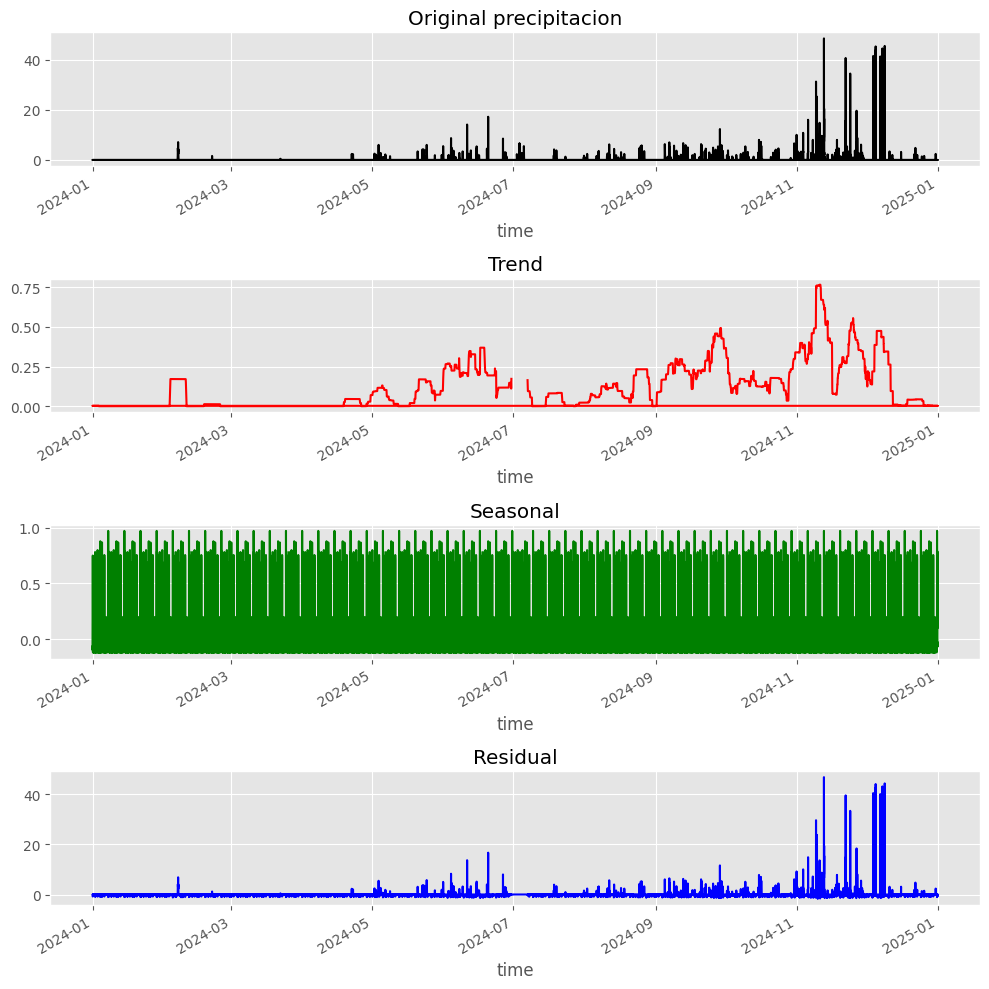

In [16]:
df_ciudad = preprocesar_ciudad('RIOHACHA')
analizar_ciudad(df_ciudad)
boxplot_mes_ciudad(df_ciudad)
barplot_coco_frecuencia(df_ciudad)
estadisticas_precipitacion(df_ciudad)
analisis_temporal(df_ciudad)
columnas_interes = ["temp", "rhum", "precipitacion", "wspd"]
correlaciones_ciudad(df_ciudad, columnas_interes)
trend1 , seasonal1, residual1 = descompose_time_series(df_ciudad['precipitacion'],1008)

# Análisis Pasto


>>> Resumen del DataFrame original para PASTO:

+-------------------+------------------+------------------+-----------------+-----------------+----+------------------+-----------------+-------------+
|               time|              temp|              dwpt|             rhum|             wdir|wspd|              pres|             coco|precipitacion|
+-------------------+------------------+------------------+-----------------+-----------------+----+------------------+-----------------+-------------+
|2024-01-01 00:00:00|              17.2|              15.6|             92.0|             74.0| 2.9|            1017.2|              8.0|          0.0|
|2024-01-01 00:10:00|17.183333333333334|             15.65|92.33333333333333|71.33333333333333| 2.9|1017.3166666666667|7.166666666666667|          0.0|
|2024-01-01 00:20:00|17.166666666666668|15.700000000000001|92.66666666666667|68.66666666666667| 2.9|1017.4333333333334|6.333333333333333|          0.0|
|2024-01-01 00:30:00|             17.15

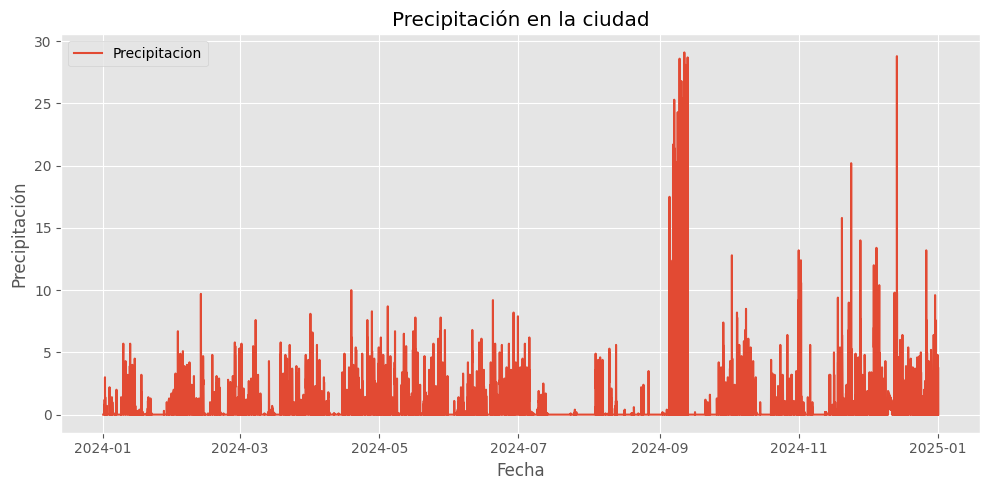

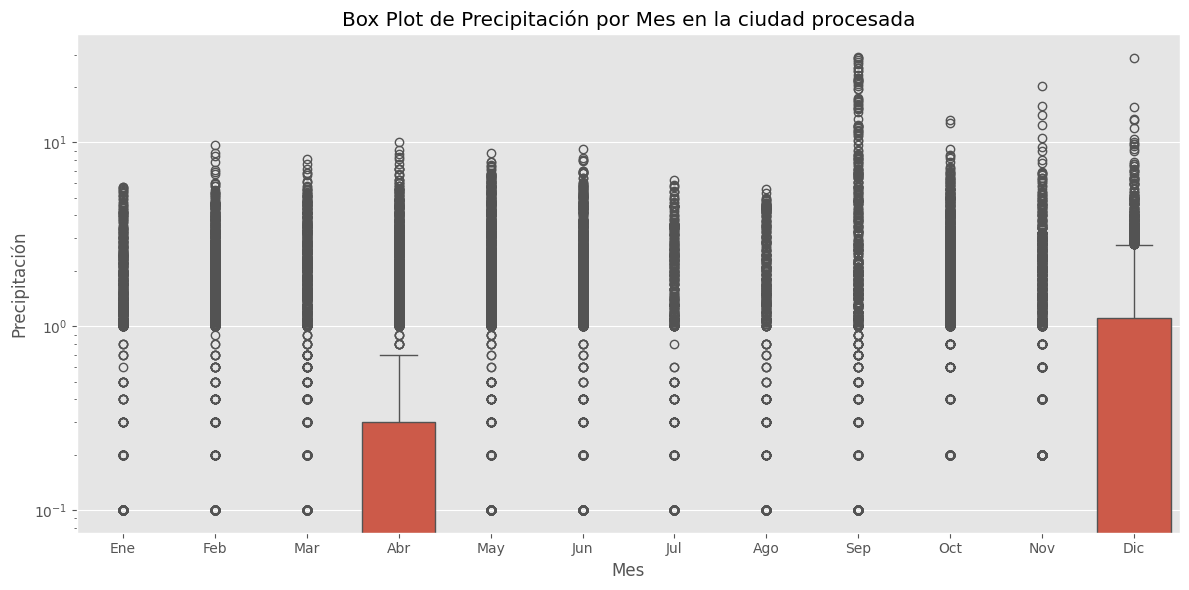

⚠️ Error procesando el DataFrame: name 'df' is not defined


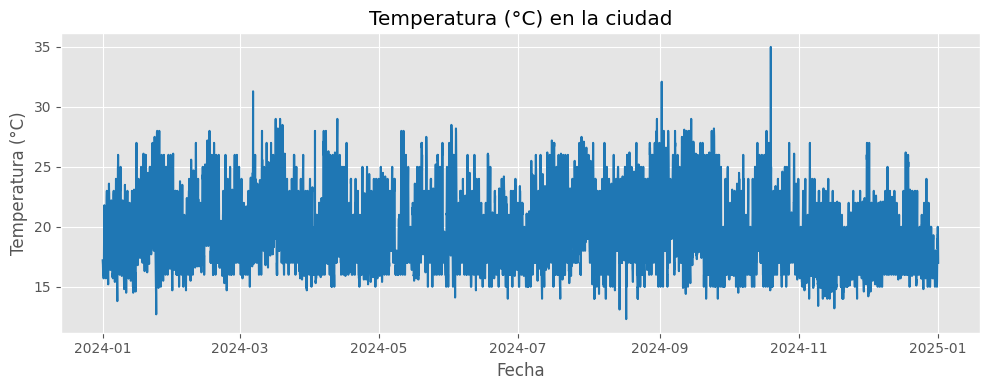

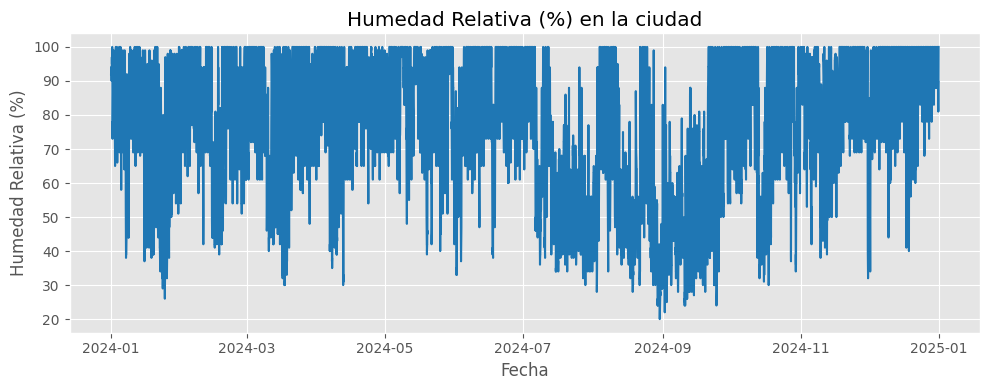

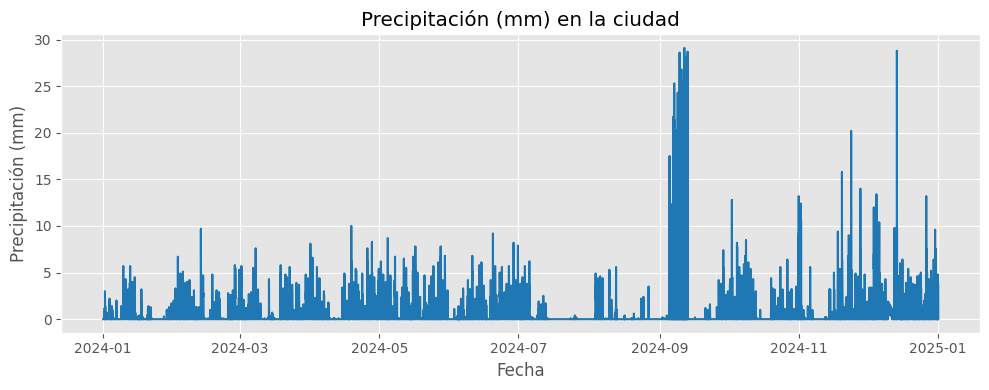

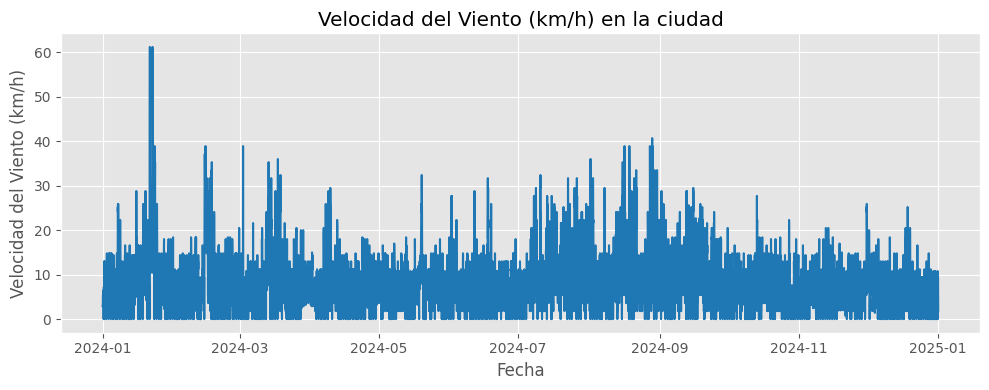


>>> Correlaciones entre columnas: ['temp', 'rhum', 'precipitacion', 'wspd']



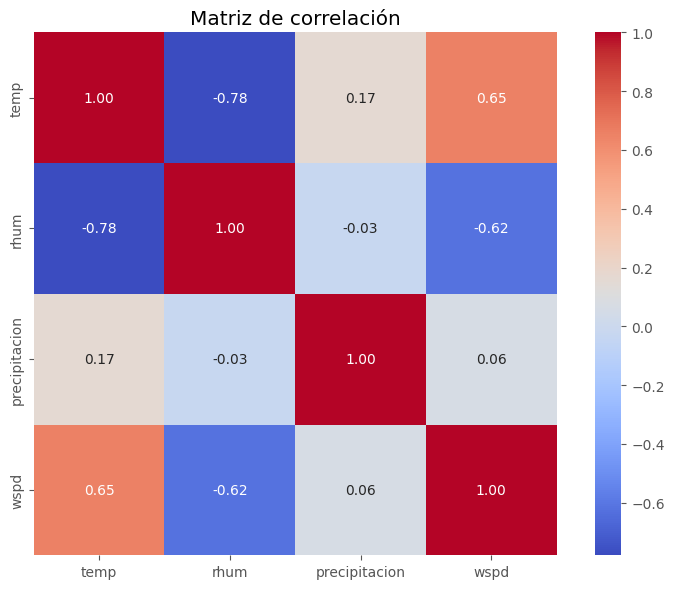

• Correlación entre 'temp' y 'rhum': -0.78 → Fuerte relación negativa.
• Correlación entre 'temp' y 'precipitacion': 0.17 → Relación insignificante.
• Correlación entre 'temp' y 'wspd': 0.65 → Relación moderada positiva.
• Correlación entre 'rhum' y 'precipitacion': -0.03 → Relación insignificante.
• Correlación entre 'rhum' y 'wspd': -0.62 → Relación moderada negativa.
• Correlación entre 'precipitacion' y 'wspd': 0.06 → Relación insignificante.


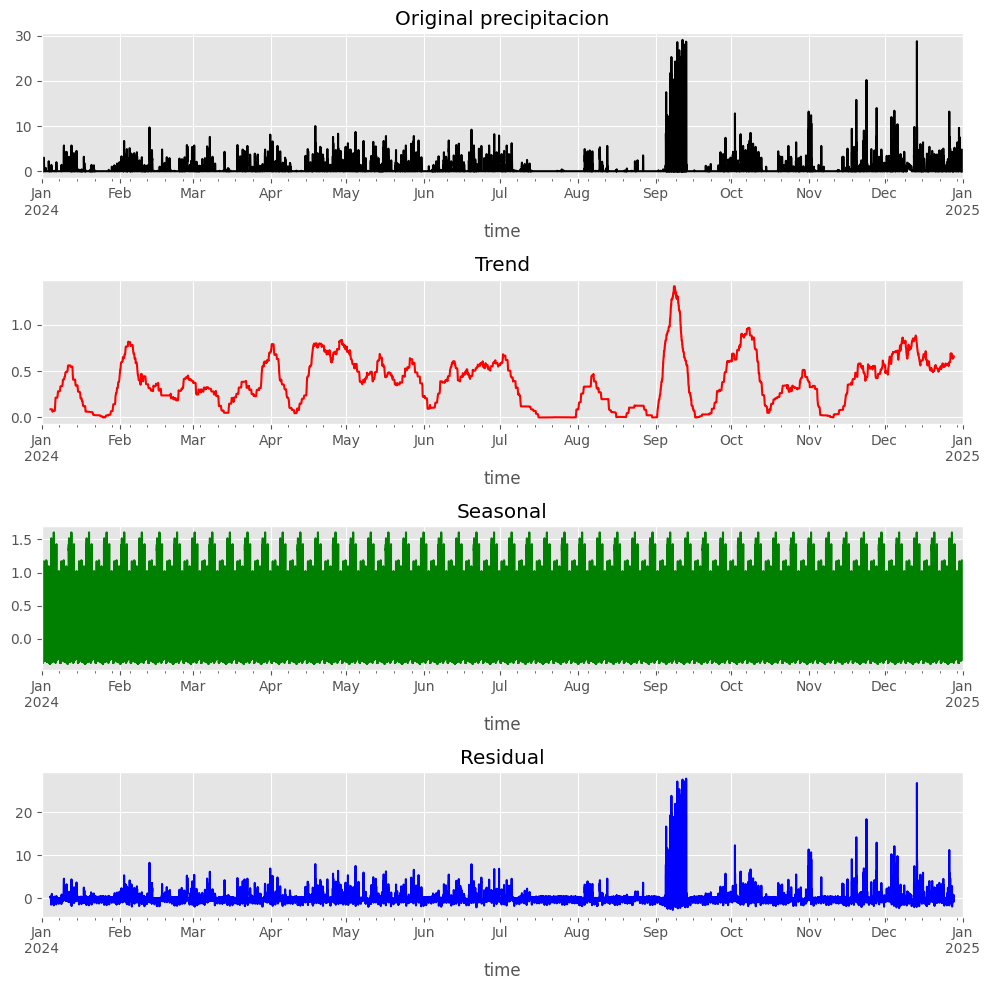

In [17]:
df_ciudad = preprocesar_ciudad('PASTO')
analizar_ciudad(df_ciudad)
boxplot_mes_ciudad(df_ciudad)
barplot_coco_frecuencia(df_ciudad)
estadisticas_precipitacion(df_ciudad)
analisis_temporal(df_ciudad)
columnas_interes = ["temp", "rhum", "precipitacion", "wspd"]
correlaciones_ciudad(df_ciudad, columnas_interes)
trend1 , seasonal1, residual1 = descompose_time_series(df_ciudad['precipitacion'],1008)

# Análisis Cúcuta


>>> Resumen del DataFrame original para CÚCUTA:

+-------------------+-----------------+------------------+------------------+------------------+------------------+------------------+----+-------------+
|               time|             temp|              dwpt|              rhum|              wdir|              wspd|              pres|coco|precipitacion|
+-------------------+-----------------+------------------+------------------+------------------+------------------+------------------+----+-------------+
|2024-07-03 21:20:00|32.86666666666667| 23.53333333333333|53.333333333333336|236.66666666666669|17.533333333333335|1008.9333333333333| 3.0|          0.0|
|2024-07-03 21:30:00|             32.9|              23.5|              53.0|             180.0|              17.3|           1008.95| 3.0|          0.0|
|2024-07-03 21:40:00|32.93333333333333|23.466666666666665|52.666666666666664|123.33333333333334|17.066666666666666|1008.9666666666667| 3.0|          0.0|
|2024-07-03 21:50:00|32.96

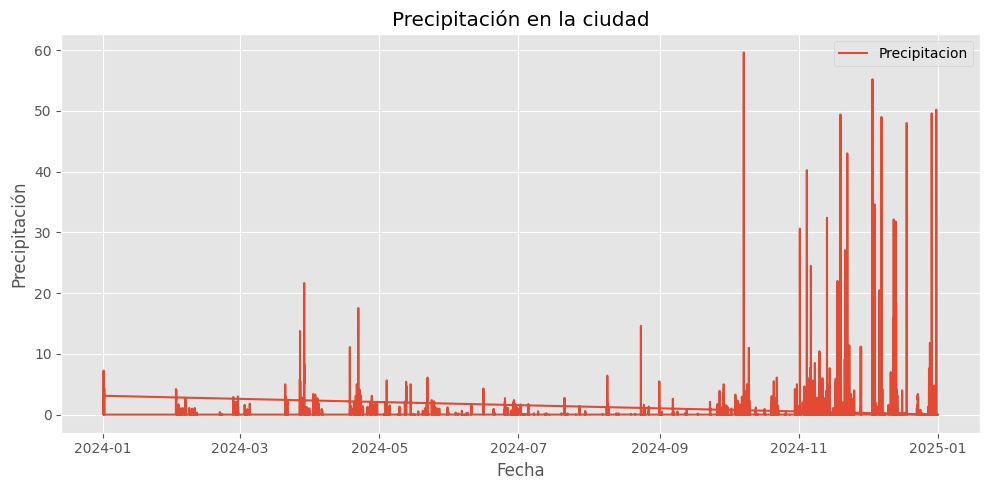

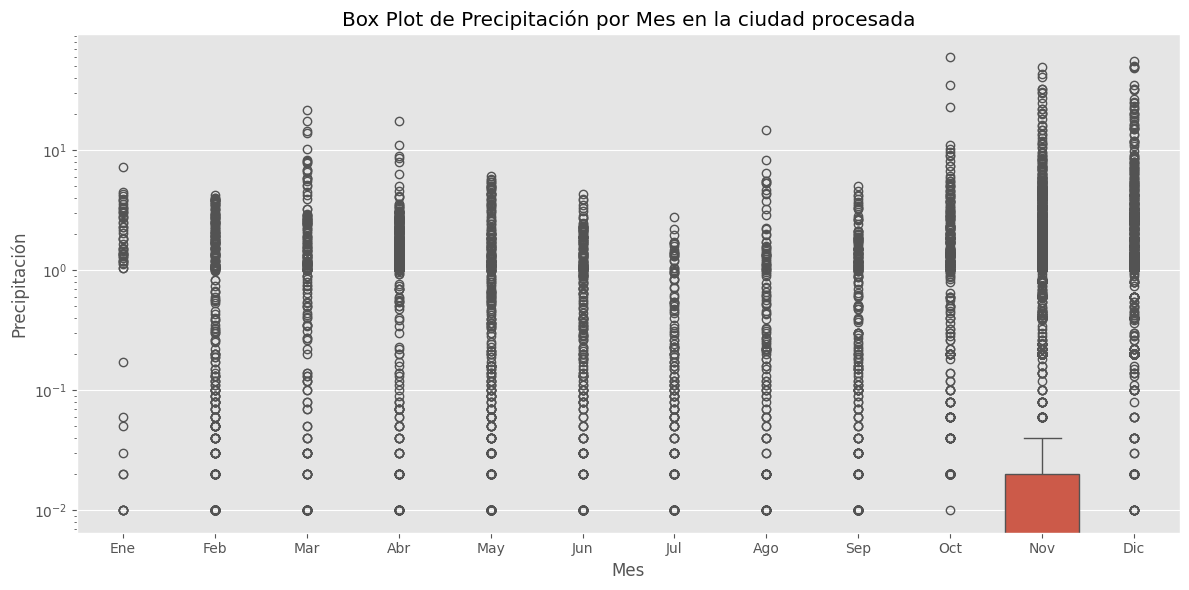

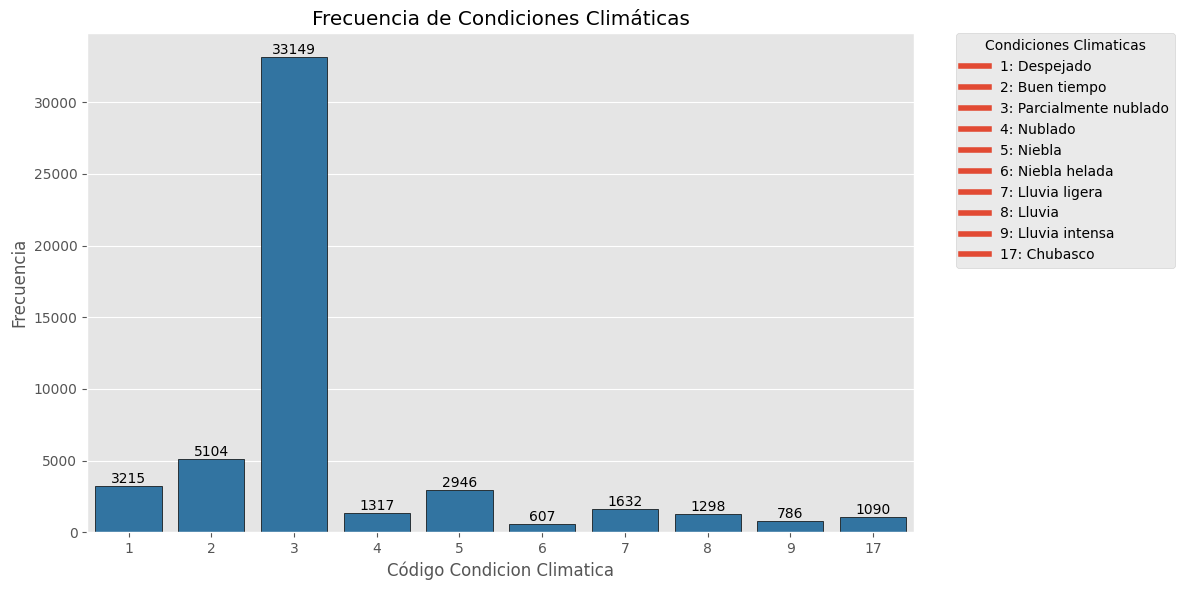


 Estadísticas de precipitación:

• Media: 0.13
• Mediana: 0.00
• Moda: 0.0
• Mínimo: 0.0 el 2024-07-03
• Máximo: 59.620000000000005 el 2024-10-07



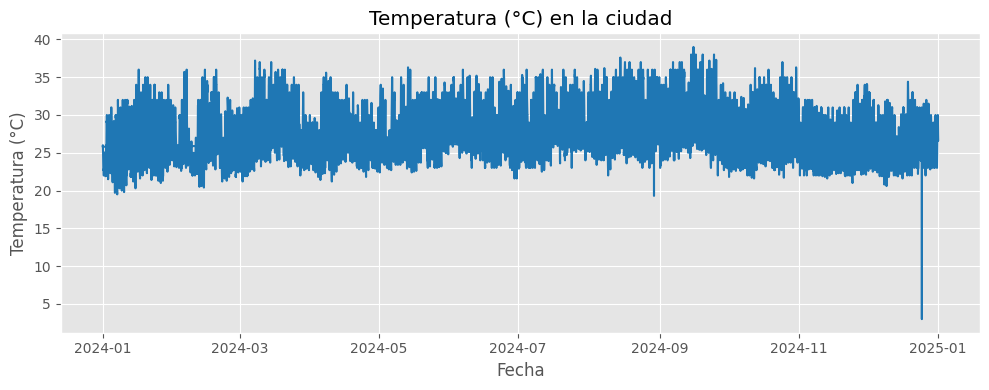

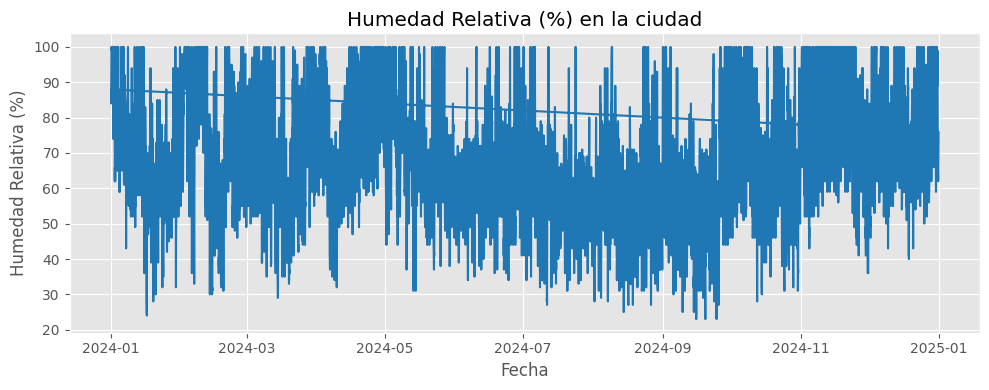

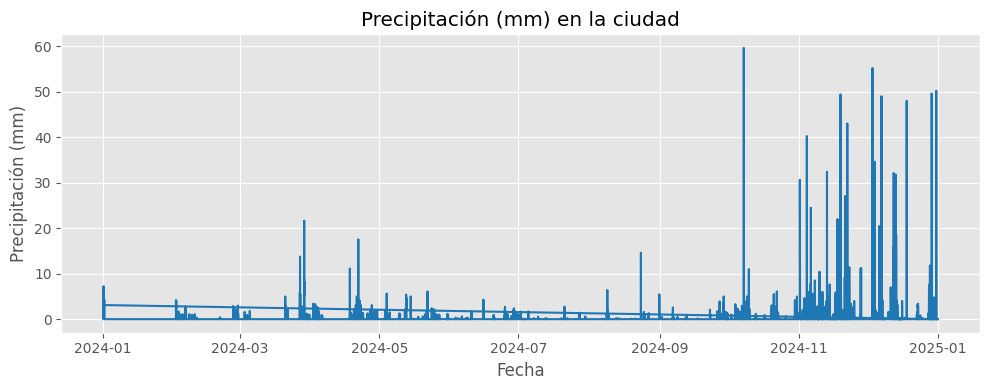

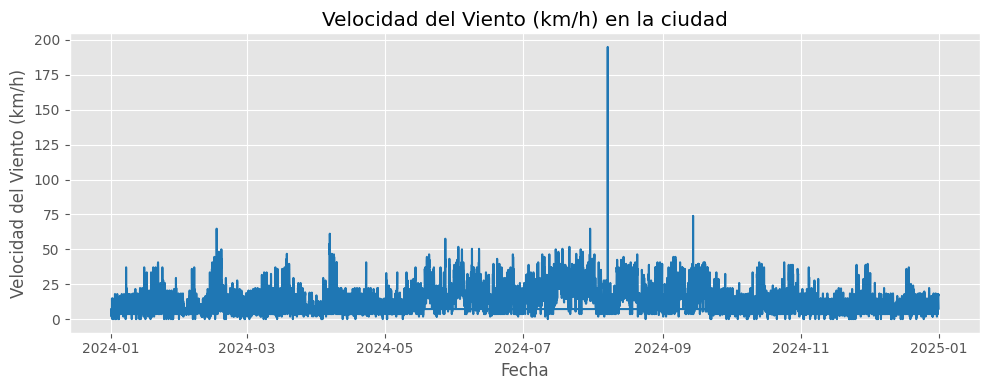


>>> Correlaciones entre columnas: ['temp', 'rhum', 'precipitacion', 'wspd']



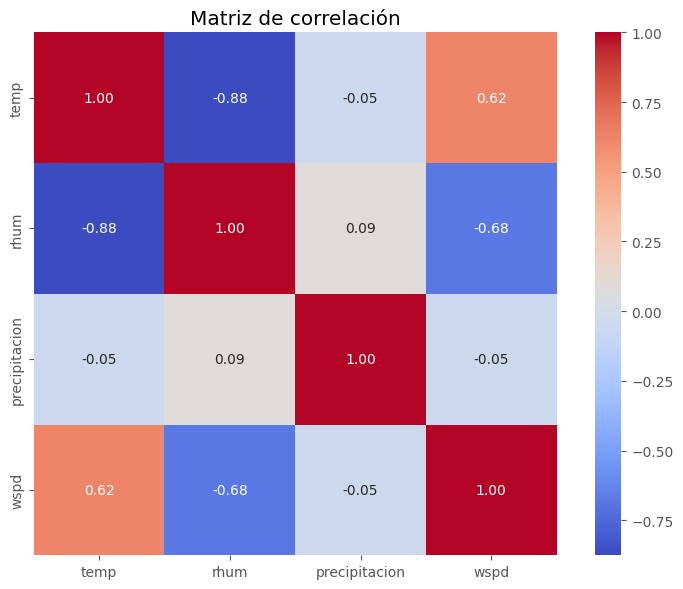

• Correlación entre 'temp' y 'rhum': -0.88 → Fuerte relación negativa.
• Correlación entre 'temp' y 'precipitacion': -0.05 → Relación insignificante.
• Correlación entre 'temp' y 'wspd': 0.62 → Relación moderada positiva.
• Correlación entre 'rhum' y 'precipitacion': 0.09 → Relación insignificante.
• Correlación entre 'rhum' y 'wspd': -0.68 → Relación moderada negativa.
• Correlación entre 'precipitacion' y 'wspd': -0.05 → Relación insignificante.


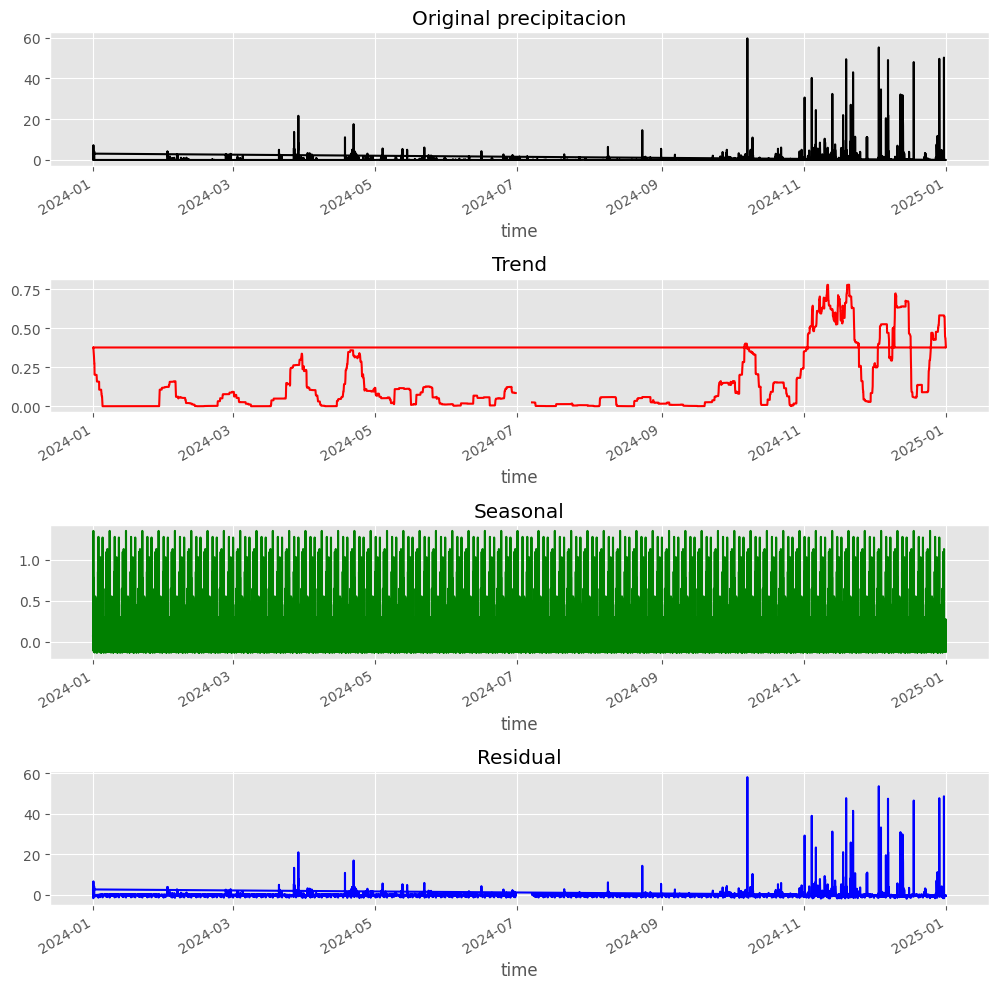

In [65]:
df_ciudad = preprocesar_ciudad('CÚCUTA')
analizar_ciudad(df_ciudad)
boxplot_mes_ciudad(df_ciudad)
barplot_coco_frecuencia(df_ciudad)
estadisticas_precipitacion(df_ciudad)
analisis_temporal(df_ciudad)
columnas_interes = ["temp", "rhum", "precipitacion", "wspd"]
correlaciones_ciudad(df_ciudad, columnas_interes)
trend1 , seasonal1, residual1 = descompose_time_series(df_ciudad['precipitacion'],1008)

# Análisis Armenia


>>> Resumen del DataFrame original para ARMENIA:

+-------------------+----+------------------+-----------------+------------------+------------------+------------------+-----------------+------------------+
|               time|temp|              dwpt|             rhum|              wdir|              wspd|              pres|             coco|     precipitacion|
+-------------------+----+------------------+-----------------+------------------+------------------+------------------+-----------------+------------------+
|2024-07-03 21:20:00|24.0|19.333333333333336|76.66666666666667|233.33333333333334| 7.200000000000001|1013.3333333333334|8.333333333333334|2.3666666666666663|
|2024-07-03 21:30:00|24.0|19.200000000000003|             76.0|             175.0|               5.4|            1013.5|              8.5|3.0999999999999996|
|2024-07-03 21:40:00|24.0|19.066666666666666|75.33333333333333|116.66666666666669|3.6000000000000005|1013.6666666666666|8.666666666666666|3.8333333333333326|
|

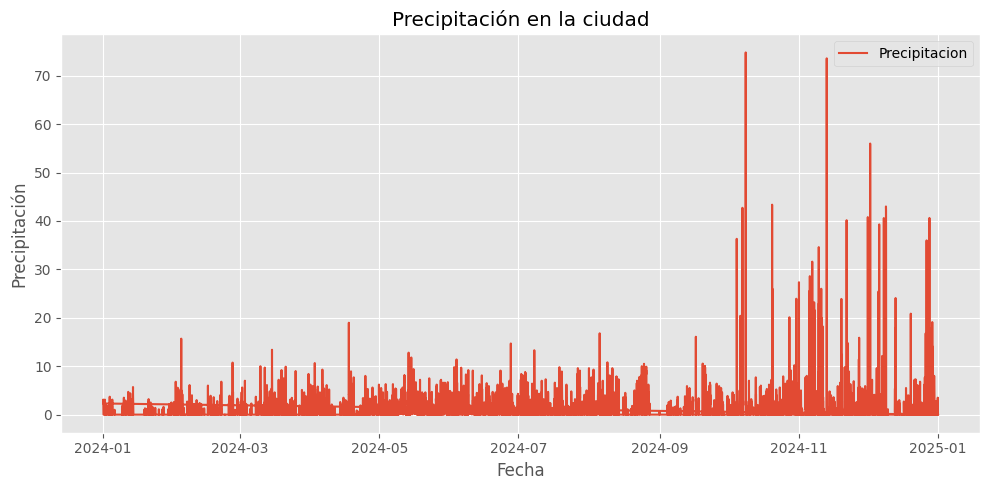

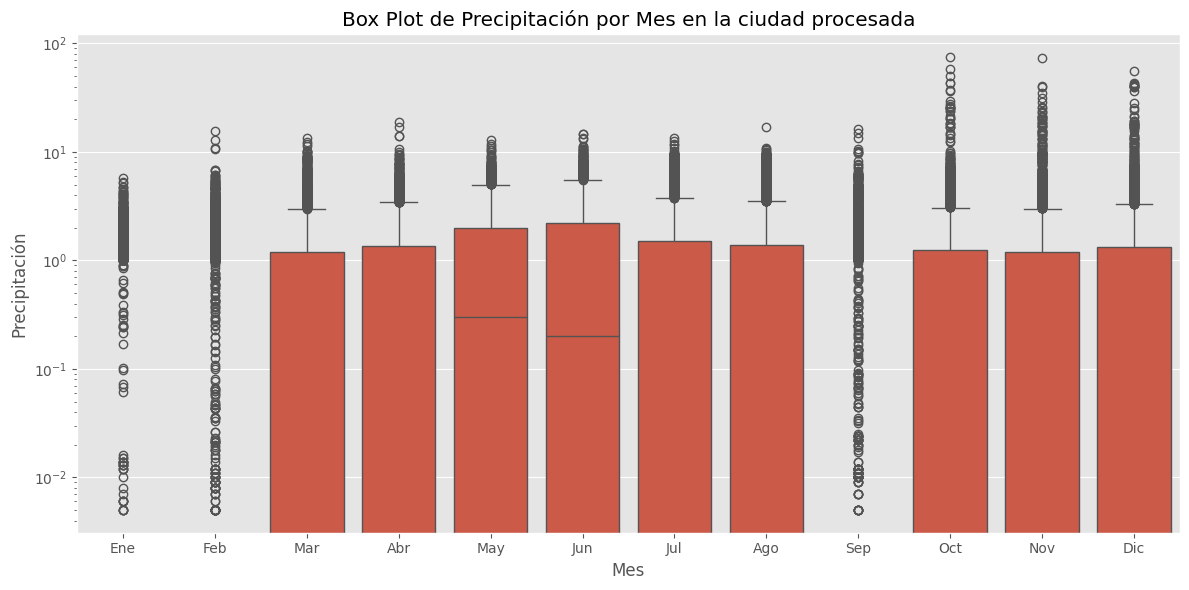

⚠️ Error procesando el DataFrame: name 'df' is not defined


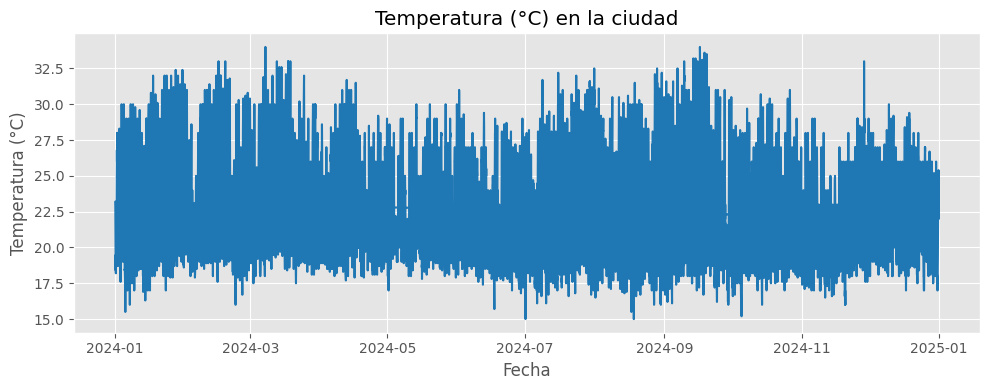

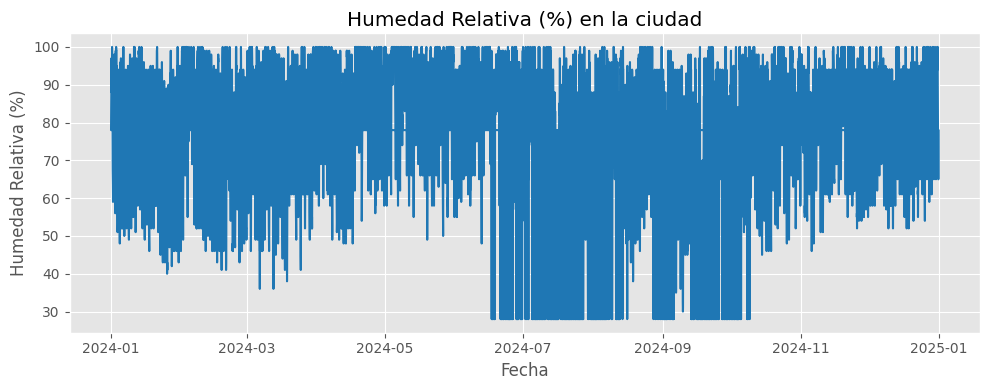

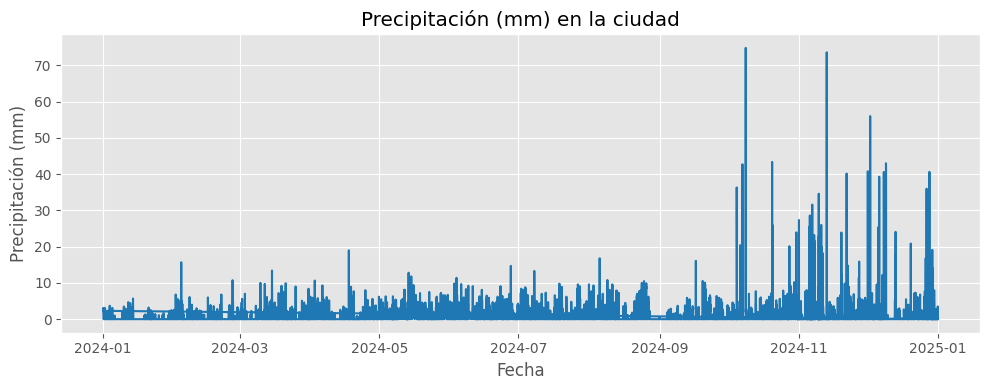

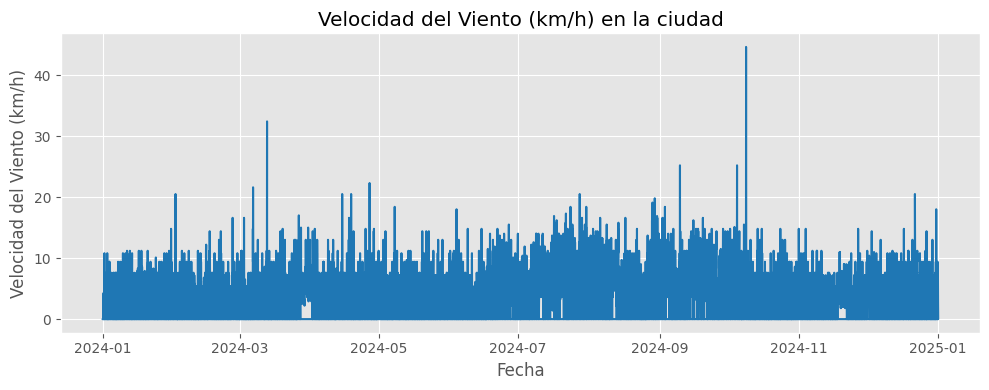


>>> Correlaciones entre columnas: ['temp', 'rhum', 'precipitacion', 'wspd']



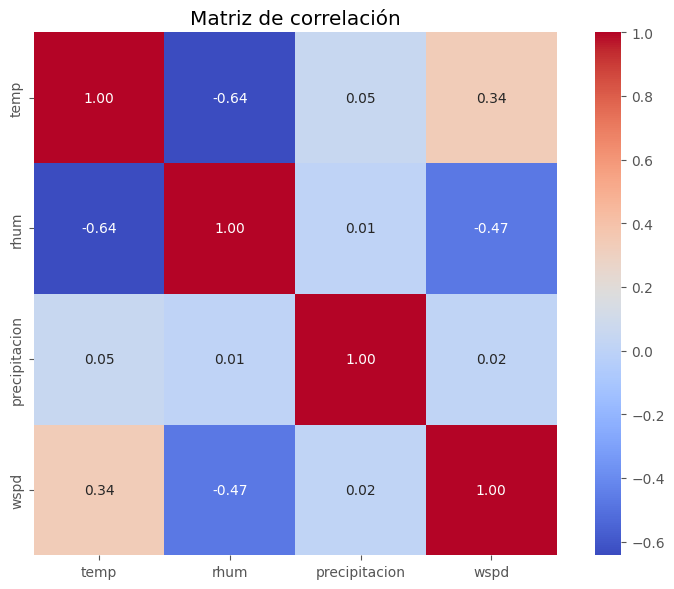

• Correlación entre 'temp' y 'rhum': -0.64 → Relación moderada negativa.
• Correlación entre 'temp' y 'precipitacion': 0.05 → Relación insignificante.
• Correlación entre 'temp' y 'wspd': 0.34 → Relación débil positiva.
• Correlación entre 'rhum' y 'precipitacion': 0.01 → Relación insignificante.
• Correlación entre 'rhum' y 'wspd': -0.47 → Relación débil negativa.
• Correlación entre 'precipitacion' y 'wspd': 0.02 → Relación insignificante.


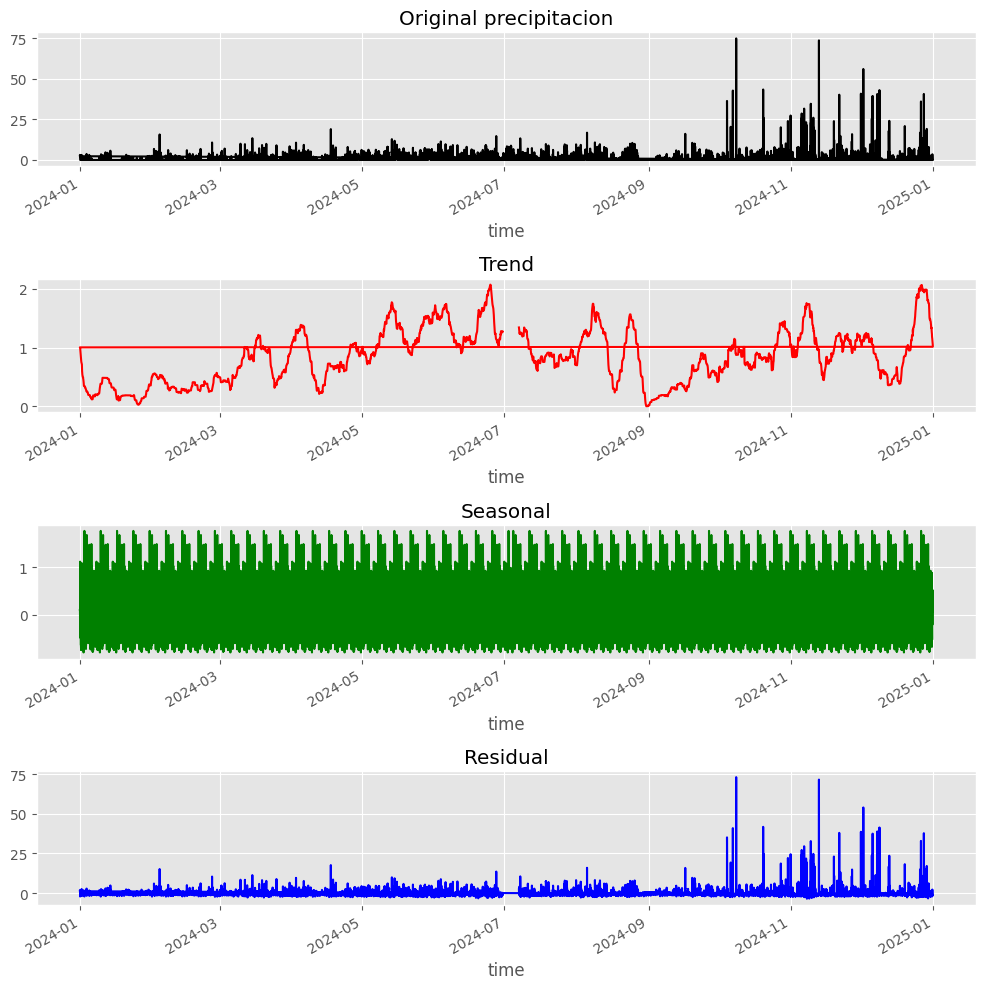

In [19]:
df_ciudad = preprocesar_ciudad('ARMENIA')
analizar_ciudad(df_ciudad)
boxplot_mes_ciudad(df_ciudad)
barplot_coco_frecuencia(df_ciudad)
estadisticas_precipitacion(df_ciudad)
analisis_temporal(df_ciudad)
columnas_interes = ["temp", "rhum", "precipitacion", "wspd"]
correlaciones_ciudad(df_ciudad, columnas_interes)
trend1 , seasonal1, residual1 = descompose_time_series(df_ciudad['precipitacion'],1008)

# Análisis San Andrés


>>> Resumen del DataFrame original para SAN ANDRÉS:

+-------------------+-----+------------------+-----------------+----+------------------+------------------+----+-------------+
|               time| temp|              dwpt|             rhum|wdir|              wspd|              pres|coco|precipitacion|
+-------------------+-----+------------------+-----------------+----+------------------+------------------+----+-------------+
|2024-07-03 21:20:00| 24.8|24.666666666666668|99.33333333333333|80.0|10.933333333333334|1009.8000000000001| 3.0|          0.0|
|2024-07-03 21:30:00|24.85|             24.75|             99.5|80.0|              11.0|            1009.6| 3.0|          0.0|
|2024-07-03 21:40:00| 24.9|24.833333333333332|99.66666666666667|80.0|11.066666666666666|            1009.4| 3.0|          0.0|
|2024-07-03 21:50:00|24.95|24.916666666666668|99.83333333333333|80.0|11.133333333333333|            1009.2| 3.0|          0.1|
|2024-07-03 22:00:00| 25.0|              25.0|           

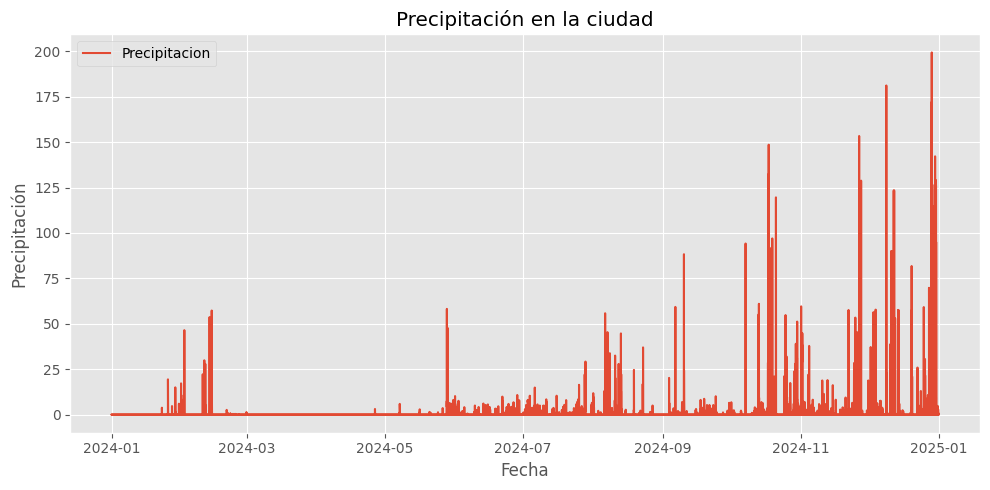

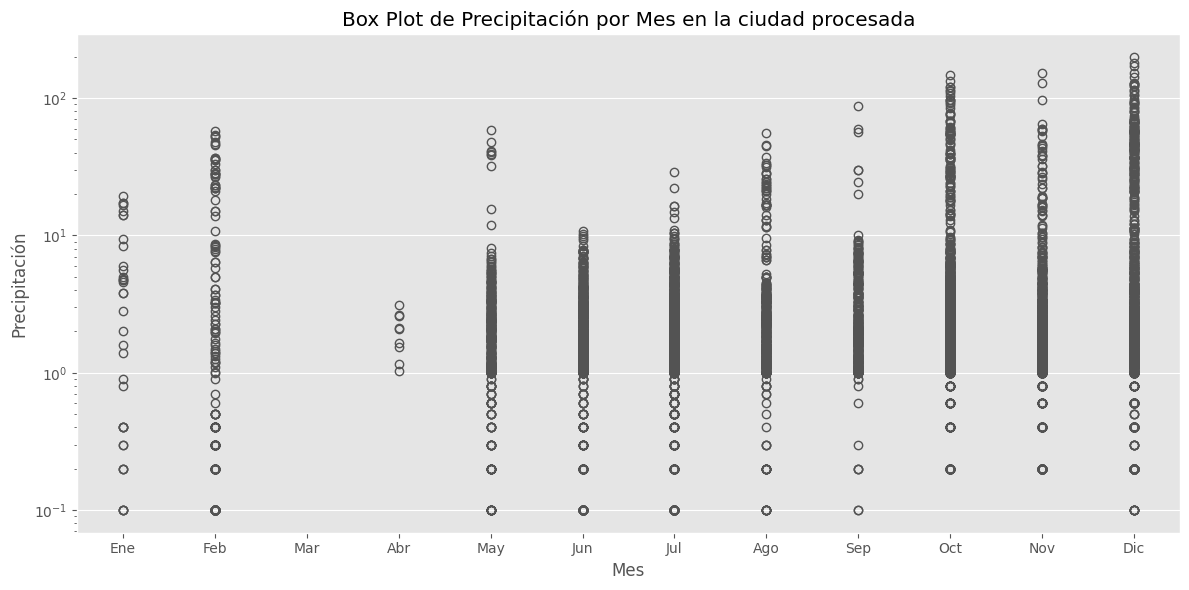

⚠️ Error procesando el DataFrame: name 'df' is not defined


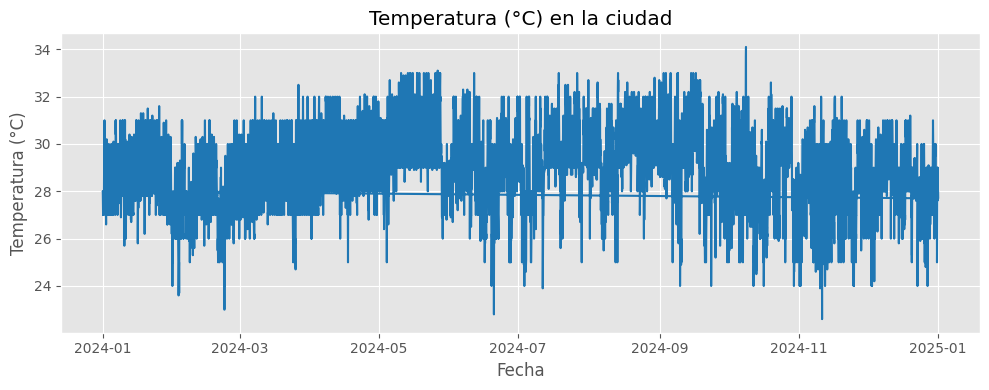

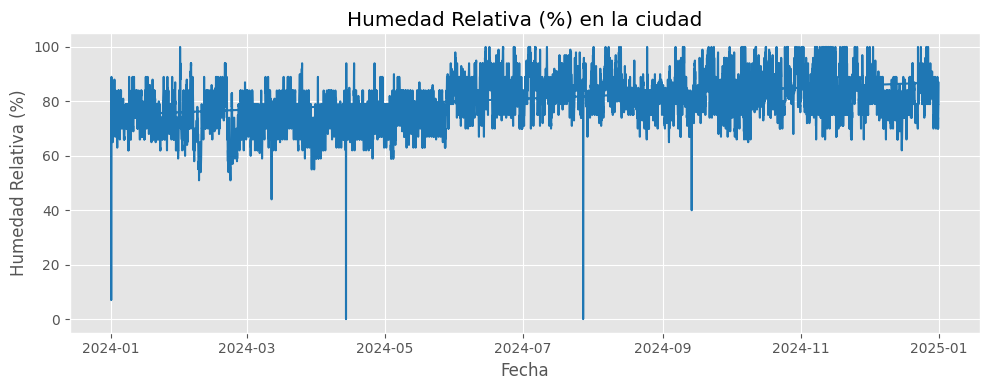

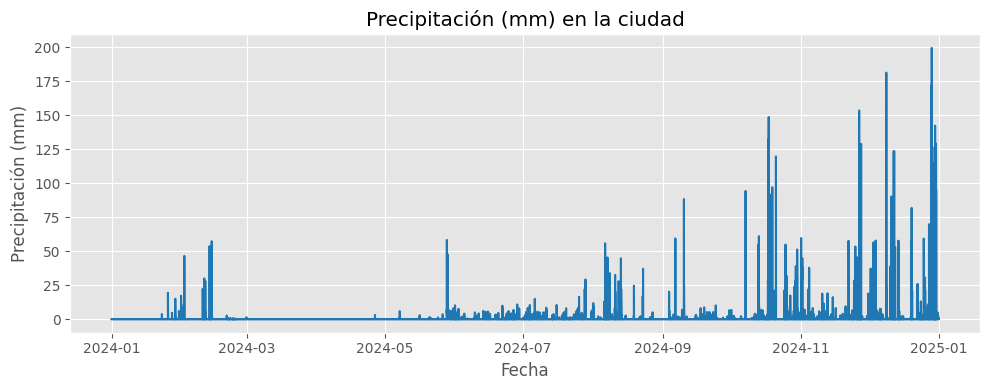

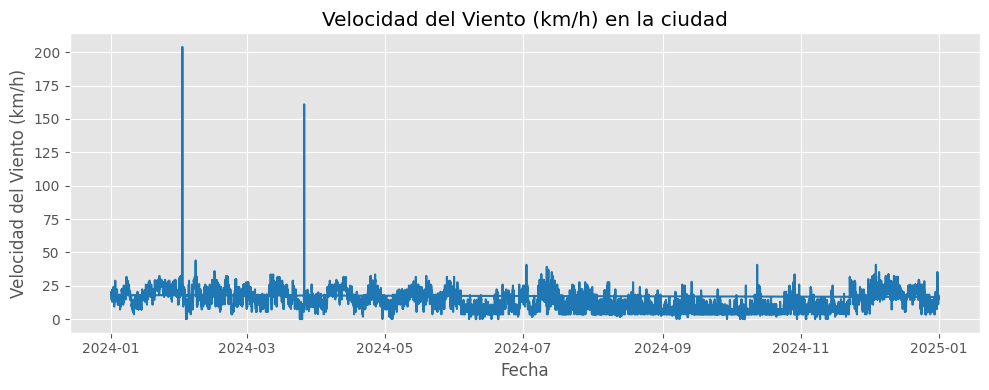


>>> Correlaciones entre columnas: ['temp', 'rhum', 'precipitacion', 'wspd']



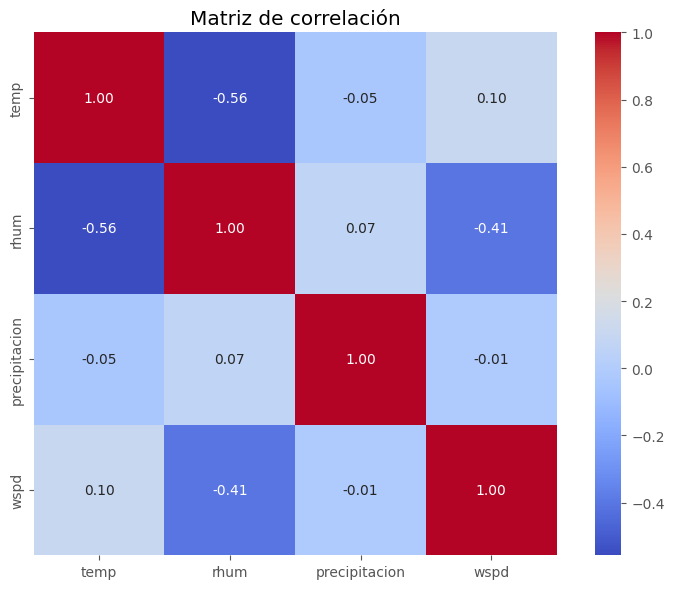

• Correlación entre 'temp' y 'rhum': -0.56 → Relación moderada negativa.
• Correlación entre 'temp' y 'precipitacion': -0.05 → Relación insignificante.
• Correlación entre 'temp' y 'wspd': 0.10 → Relación insignificante.
• Correlación entre 'rhum' y 'precipitacion': 0.07 → Relación insignificante.
• Correlación entre 'rhum' y 'wspd': -0.41 → Relación débil negativa.
• Correlación entre 'precipitacion' y 'wspd': -0.01 → Relación insignificante.


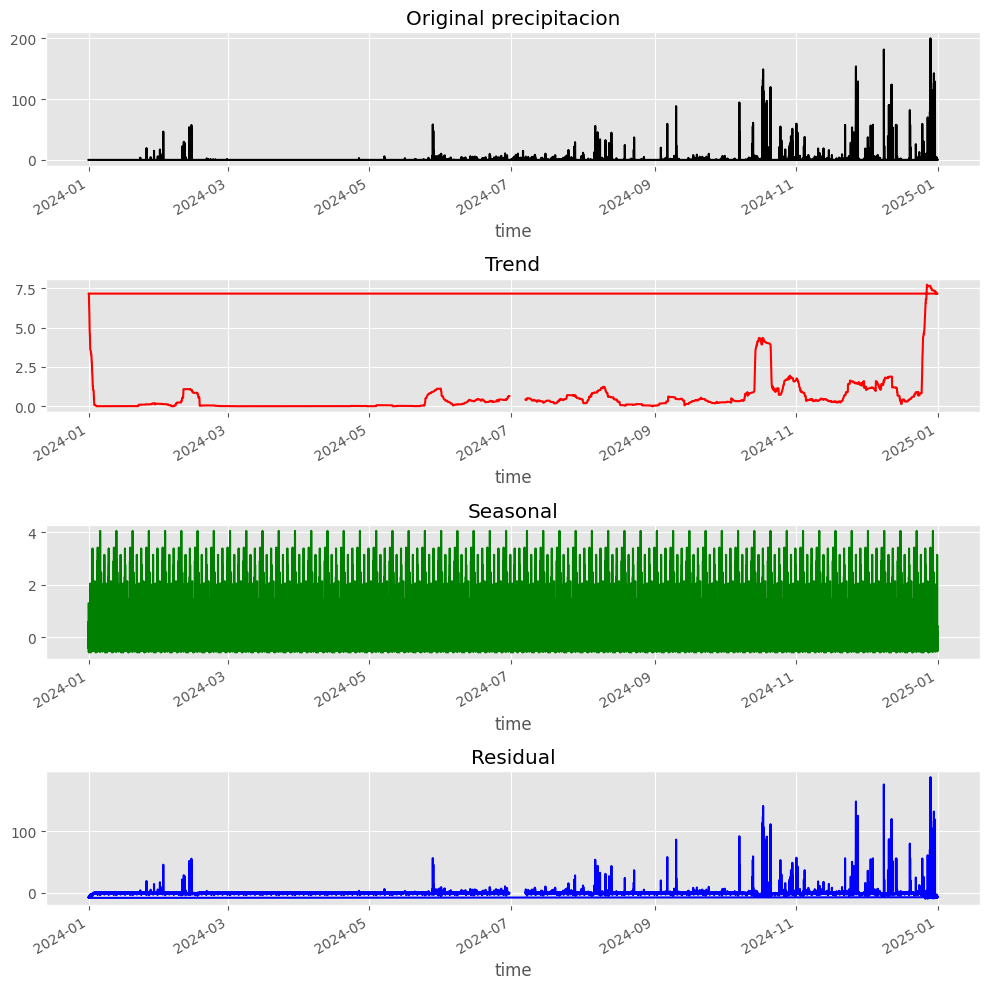

In [20]:
df_ciudad = preprocesar_ciudad('SAN ANDRÉS')
analizar_ciudad(df_ciudad)
boxplot_mes_ciudad(df_ciudad)
barplot_coco_frecuencia(df_ciudad)
estadisticas_precipitacion(df_ciudad)
analisis_temporal(df_ciudad)
columnas_interes = ["temp", "rhum", "precipitacion", "wspd"]
correlaciones_ciudad(df_ciudad, columnas_interes)
trend1 , seasonal1, residual1 = descompose_time_series(df_ciudad['precipitacion'],1008)

# ¿Cómo varía temporalmente la precipitación por ciudad a lo largo del 2024?

 A lo largo del año 2024, se observa un patrón general de comportamiento de la precipitación en la mayoría de las ciudades analizadas. Específicamente, durante la primera mitad del año (enero a junio), la precipitación tiende a ser baja o casi nula. Sin embargo, a partir de mediados de año, se registra un aumento progresivo en los niveles de precipitación, alcanzando su punto máximo hacia los últimos meses del año (noviembre y diciembre). Este comportamiento sugiere una posible estacionalidad climática común en varias de las regiones estudiadas.

Aunque existe una tendencia estacional general en la mayoría de las ciudades —baja precipitación en la primera mitad del año y aumento hacia finales—, las condiciones locales específicas hacen que ciertas ciudades se comporten de manera distinta, evidenciando la diversidad climática regional del país.

No obstante, este patrón no se replica en todas las ciudades. Hay excepciones notables como Pasto, Neiva, Bogotá y San Andrés, las cuales presentan comportamientos particulares que se responderán en la siguiente pregunta.


# ¿Existen ciudades con comportamiento atípico o con mayor frecuencia de dias de lluvias intensas en 2024?

Según el análisis realizado se pueden evidenciar que hay ciertas ciudades que tienen un comportamiento atípico respecto a las demás que se puede explicar de la siguiente forma:

+ **Pasto**: Exhibe un comportamiento distinto al mostrar niveles relativamente altos de precipitación durante casi todo el año, con una breve disminución hacia la mitad del mismo. Esto puede estar relacionado con su ubicación geográfica en una zona montañosa y húmeda.

+ **Neiva**: A diferencia de otras ciudades, tiene un pico importante de precipitación en los primeros meses del año, seguido de una disminución hacia la mitad del año. Posteriormente, las lluvias aumentan de nuevo, mostrando un comportamiento más bimodal. No obstante, la intensidad de las precipitaciones en Neiva es baja, ya que en ningún momento del año se superan los 15 mm diarios, lo que indica lluvias de corta duración o de menor impacto.

+ **Bogotá**: Muestra una alta concentración de precipitaciones al inicio del año, especialmente en marzo, con algunos picos significativos, seguidos de un descenso en los meses intermedios. Posteriormente, se mantiene un nivel bajo a moderado de lluvias hacia el final del año, sin alcanzar picos comparables a los del primer trimestre. Esto sugiere que el régimen de lluvias en Bogotá en 2024 fue más activo a comienzos del año, con una tendencia a la estabilidad en los meses siguientes.

+ **San Andrés**: Se destaca como la ciudad con mayor precipitación acumulada y eventos extremos de lluvia en 2024. Aunque presenta un periodo seco prolongado en la primera mitad del año, a partir de agosto se observa un aumento rápido y sostenido en la cantidad y frecuencia de lluvias intensas. En los últimos meses del año (octubre a diciembre), se registran múltiples días con precipitaciones superiores a 150 mm, alcanzando picos cercanos a 200 mm diarios. Este comportamiento indica una alta exposición a lluvias torrenciales que pueden explicarse por la posicion geográfica del archipiélago, posicionando a San Andrés como un caso excepcional frente al resto de ciudades analizadas.

# ¿Qué relaciones se observan entre la precipitación diaria y otras variables meteorológicas (temperatura media, humedad relativa, velocidad del viento) durante 2024?

Podemos concluir a partir de las matrices de correlacion de las ciudades diferentes relaciones:
La precipitacion tiene relacion negativa con la humedad relativa, al igual que humedad relativa con la velocidad del viento. Indicando que si alguna de estas dos variables detectadas se encuentra en un valor elevado, la otra tendrá un valor menor. De igual manera se percibe una relacion positiva entre la temperatura y la velocidad del viento